In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.manifold import TSNE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from bs4 import BeautifulSoup
import scipy
from scipy.sparse import coo_matrix, hstack


# Dataset loading

In [3]:
#Dataset loading
dataset2 = pd.read_csv('Cleaned_Posts.csv', nrows = None, index_col=0)
dataset2.shape

(49399, 10)

In [4]:
#Any np.nan ?
dataset2.isnull().sum()

TText             0
TText_NEG         0
PText             0
TCode         10054
PCode          9627
TTitle            0
TTitle_NEG        0
Title             0
PTags             0
Tags              0
dtype: int64

In [5]:
#np.nan cleaning
dataset2['TCode'] = dataset2['TCode'].fillna('None')
dataset2['PCode'] = dataset2['PCode'].fillna('None')

In [6]:
#Any np.nan ?
dataset2.isnull().sum()

TText         0
TText_NEG     0
PText         0
TCode         0
PCode         0
TTitle        0
TTitle_NEG    0
Title         0
PTags         0
Tags          0
dtype: int64

In [9]:
df = pd.DataFrame(dataset2['PTags'].tolist()).stack().value_counts()
#df = df[df>50]
df.shape

(36578,)

In [10]:
existintags = set(df.index)
existintags

{"['xamarin.forms', 'android-emulator', 'rendering']",
 "['json', 'angular', 'api', 'symfony']",
 "['php', 'apache', 'wamp']",
 "['node.js', 'promise', 'stream']",
 "['google-cloud-platform', 'maven-3', 'google-cloud-dataflow', 'apache-beam']",
 "['xcode', 'artoolkit', 'iphone-ar-toolkit']",
 "['visual-studio', 'xamarin.forms']",
 "['sql', 'sql-server', 'performance', 'null']",
 "['pdfminer']",
 "['php', 'laravel-5']",
 "['hadoop', 'apache-spark', 'zeppelin', 'livy']",
 "['c++', 'struct']",
 "['ios', 'objective-c', 'uitableview', 'uisearchbar', 'uisearchcontroller']",
 "['java', 'android', 'search', 'textwatcher']",
 "['visual-studio', 'resharper']",
 "['ios', 'swift3', 'uicollectionview']",
 "['laravel', 'sublimetext3']",
 "['sublimetext3']",
 "['android', 'xml', 'android-constraintlayout', 'constraint-layout']",
 "['docker', 'networking', 'docker-swarm']",
 "['jquery', 'youtube']",
 "['material']",
 "['html', 'razor', 'umbraco', 'truncate']",
 "['mongodb', 'scala', 'hadoop', 'apache-

# Dataset splitting

In [11]:
#Downsampling
dataset = dataset2.sample(10000)
dataset.shape

(10000, 10)

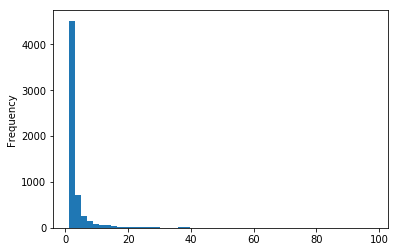

In [12]:
#Most commons tags
dataset['PTags'] = dataset['Tags'].apply(lambda x: [tag.name for tag in BeautifulSoup(x, 'html.parser').find_all()])
df = pd.DataFrame(dataset['PTags'].tolist()).stack().value_counts()
df[df<100].plot(kind = 'hist', bins = 50)
plt.show()

In [13]:
popularitytags = df[df>50].to_dict()
len(popularitytags)

68

In [14]:
#Tags cleaning
textset = dataset.copy()
textset['PTagsCleaned'] = textset['PTags'].apply(lambda x: [tag for tag in x if tag in popularitytags.keys()])
textset['PTagsCleanedLen'] = textset['PTagsCleaned'].apply(lambda x: len(x))
textset = textset[textset['PTagsCleanedLen'] != 0]
textset = textset.dropna()
print(textset.shape)
textset[['PTagsCleaned', 'PTags', 'TCode']].head()

(7861, 12)


PTagsCleaned                                       PTags  \
Id                                                                          
48120430  [ios, react-native]  [ios, svg, react-native, react-native-ios]   
48112933    [android, string]                   [android, string, locale]   
48140066                [ios]                   [ios, storyboard, swift4]   
48076566         [javascript]                      [javascript, three.js]   
48184878                [ios]                          [ios, cocoa-touch]   

                                                      TCode  
Id                                                           
48120430  " dependencies ": {" better - fetch ": "^ . . ...  
48112933  Locale . RO public Locale ( String language , ...  
48140066  tableView leading = trailing = stack view lead...  
48076566                                               None  
48184878                                               None

In [15]:
#X set creation
X = textset[['TText', 'TTitle', 'TCode']]

In [16]:
#Label dataset creation

y = textset['PTagsCleaned']

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(y)
Y.shape

(7861, 68)

In [17]:
#Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0, shuffle = True)

In [18]:
mlb.classes_

array(['ajax', 'amazon-web-services', 'android', 'angular', 'angularjs',
       'api', 'arrays', 'asp.net', 'asp.net-mvc', 'azure', 'bash', 'c',
       'c#', 'c++', 'css', 'database', 'django', 'docker', 'excel',
       'excel-vba', 'express', 'firebase', 'forms', 'git', 'html',
       'ionic-framework', 'ios', 'java', 'javascript', 'jquery', 'json',
       'laravel', 'linux', 'mongodb', 'multithreading', 'mysql', 'node.js',
       'numpy', 'pandas', 'php', 'postgresql', 'powershell', 'python',
       'python-2.7', 'python-3.x', 'r', 'react-native', 'reactjs', 'regex',
       'ruby', 'ruby-on-rails', 'spring', 'spring-boot', 'sql',
       'sql-server', 'string', 'swift', 'tensorflow', 'twitter-bootstrap',
       'typescript', 'vba', 'visual-studio', 'vue.js', 'windows',
       'wordpress', 'wpf', 'xcode', 'xml'], dtype=object)

# LDA version

In [19]:

class CustomLDA(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.lda_params = {'n_components':10, 'random_state':0, 'doc_topic_prior':None, 'topic_word_prior':None}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'lda_'+k:v for k,v in self.lda_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = CountVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #LDA preparation
        self.lda = LatentDirichletAllocation(learning_method = 'batch', **self.lda_params)
        self.lda.fit(Xtrans)
        
        self.components_ = self.lda.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        lda = self.lda.transform(self.transformcvect(X))
        return lda
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.lda_params = {k[4:]:v for k,v in self.params.items() if k.startswith('lda_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.lda_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def perplexity(self, X):
        
        return self.lda.perplexity(self.transformcvect(X))
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]



#customLDA = CustomLDA()


Some docs about the parameters : https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [20]:
topics = 50

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1),}

customLDA = CustomLDA(**params)
customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.025,
     lda_n_components=50, lda_random_state=0, lda_topic_word_prior=0.02,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [21]:
#Filling rating
customLDA.score()

12.5

In [22]:
#Main topics
customLDA.describe_topics(ntopwords=10, ntopics=20)

array([['code', '00', 'get', 'work', 'comput', 'doe', 'want', 'use',
        'error', 'like'],
       ['row', 'column', 'tabl', 'cell', 'want', 'data', 'excel', 'add',
        'one', 'code'],
       ['custom', 'creat', 'tabl', 'framework', 'class', 'set', 'program',
        'lib', 'line', 'main'],
       ['mongodb', 'book', 'collect', 'use', 'creat', 'code', '10',
        'insert', 'ipsum', 'lorem'],
       ['array', 'object', 'function', 'use', 'text', 'like', 'one',
        'creat', 'want', 'element'],
       ['form', 'field', 'input', 'submit', 'error', 'use', 'angular',
        'get', 'html', 'code'],
       ['compon', 'react', 'parent', 'child', 'tag', 'render', 'prop',
        'use', 'state', 'like'],
       ['api', 'use', 'googl', 'token', 'get', 'request', 'call', 'servic',
        'access', 'respons'],
       ['android', 'view', 'java', 'studio', 'com', 'os', 'viewgroup',
        'error', 'run', 'nativ'],
       ['select', 'delet', 'class', 'updat', 'dropdown', 'valu', 'list',

In [23]:
#Perplexity
customLDA.perplexity(X_test)

4850.3724795129756

In [26]:
customLDA.topicsnamed

{0: [],
 1: [],
 2: [],
 3: ['mongodb'],
 4: [],
 5: [],
 6: [],
 7: ['api'],
 8: ['android', 'java'],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: ['java'],
 17: [],
 18: ['docker'],
 19: ['tensorflow'],
 20: [],
 21: [],
 22: ['git'],
 23: ['django', 'spring'],
 24: ['php'],
 25: [],
 26: ['html'],
 27: [],
 28: ['spring'],
 29: ['sql', 'mysql'],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: ['css'],
 43: [],
 44: ['string'],
 45: [],
 46: [],
 47: [],
 48: [],
 49: []}

In [27]:
customLDA.namedtopics

{'android': {8},
 'api': {7},
 'css': {42},
 'django': {23},
 'docker': {18},
 'git': {22},
 'html': {26},
 'java': {8, 16},
 'mongodb': {3},
 'mysql': {29},
 'php': {24},
 'spring': {23, 28},
 'sql': {29},
 'string': {44},
 'tensorflow': {19}}

# TSNE reduction dimension

In [28]:
#customLDA
X_lda = customLDA.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_lda)

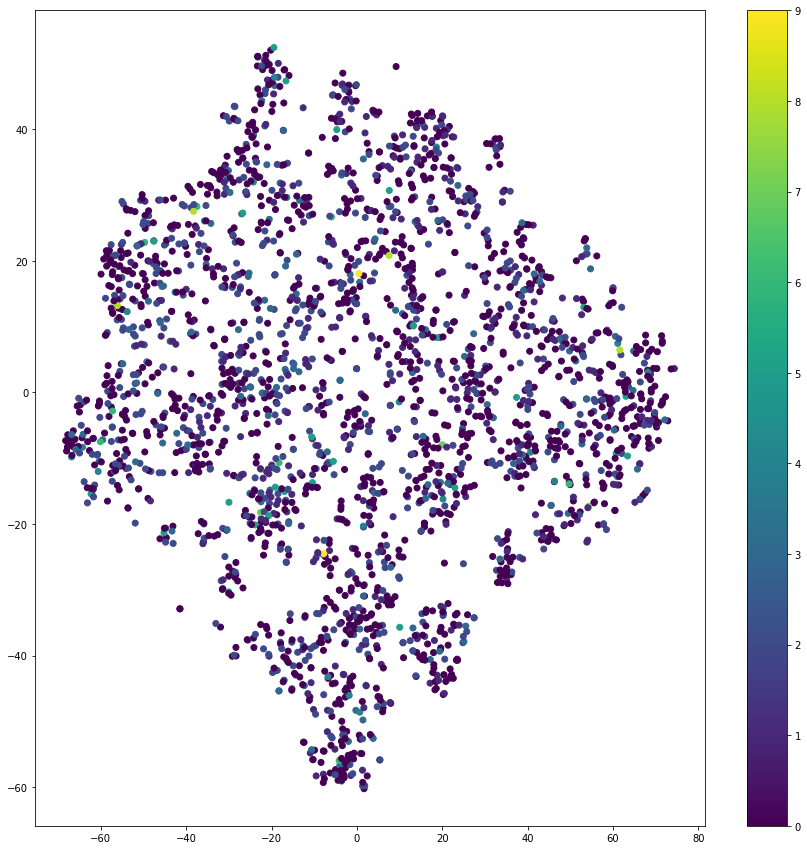

In [29]:
# plot the result
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_lda, 0)[:, 0]
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

# GridsearchCV LDA

In [36]:
#gridsearch to optimize the parameters - LDA optimization

topics = 50

params = {'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_merge': True,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 1/(topics*.8),
 'lda_n_components': topics,
 'lda_random_state': 0,
 'lda_topic_word_prior': 1/topics,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)
}

customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'lda_topic_word_prior':[ 1/(topics*1.4), 1/(topics*1.2), 1/(topics), 1/(topics*0.8), 1/(topics*0.6)],
              'clf_merge': [True, False],
             }



clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.014285714285714285 
[CV] clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.014285714285714285 
[CV] clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.014285714285714285, score=11.0, total= 1.2min
[CV] clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.016666666666666666, score=10.833333333333332, total= 1.2min
[CV] clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.02 
[CV]  clf_merge=True, lda_doc_topic_prior=0.014285714285714285, lda_topic_word_prior=0.014285714285714285, score=12.5, total= 1.2min
[CV] clf_me

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 11.0min


[CV] clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.03333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.025, score=11.0, total= 1.2min
[CV] clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.03333333333333333 
[CV]  clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.025, score=13.5, total= 1.3min
[CV] clf_merge=True, lda_doc_topic_prior=0.025, lda_topic_word_prior=0.014285714285714285 
[CV]  clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.03333333333333333, score=11.0, total= 1.2min
[CV] clf_merge=True, lda_doc_topic_prior=0.025, lda_topic_word_prior=0.014285714285714285 
[CV]  clf_merge=True, lda_doc_topic_prior=0.02, lda_topic_word_prior=0.03333333333333333, score=6.5, total= 1.3min
[CV] clf_merge=True, lda_doc_topic_prior=0.025, lda_topic_word_prior=0.016666666666666666 
[CV]  clf_merge=True, lda_doc_topic_prior=0.025, lda_topic_word_prior=0.014285714285714285, score=13.3333333333333

[CV]  clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.016666666666666666, score=8.5, total= 1.1min
[CV] clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.025 
[CV]  clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.02, score=10.0, total= 1.1min
[CV] clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.025 
[CV]  clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.02, score=9.5, total= 1.1min
[CV] clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.03333333333333333 
[CV]  clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.025, score=9.0, total= 1.1min
[CV] clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.03333333333333333 
[CV]  clf_merge=False, lda_doc_topic_prior=0.016666666666666666, lda_topic_word_prior=0.025, score=9.5, total= 1.1min


[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 38.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.025,
     lda_n_components=50, lda_random_state=0, lda_topic_word_prior=0.02,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.014285714285714285, 0.016666666666666666, 0.02, 0.025, 0.03333333333333333], 'lda_topic_word_prior': [0.014285714285714285, 0.016666666666666666, 0.02, 0.025, 0.03333333333333333], 'clf_merge': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [37]:
clf.best_params_

{'clf_merge': True,
 'lda_doc_topic_prior': 0.014285714285714285,
 'lda_topic_word_prior': 0.02}

In [38]:
clf.best_score_

13.416666666666668

In [39]:
#Parameters update
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.014285714285714285,
 'lda_n_components': 50,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.02,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

# Results comparison --> Unsupervised vs Supervised

In [40]:
#Metrics creation

#from sklearn.metrics import fbeta_score
scorer = make_scorer(f1_score, average='micro')


In [41]:
#gridsearch to optimize the parameters - TEXT merged

customLDA = CustomLDA(**params)

parameters = {'vect_1_max_df': [1., 0.9, 0.95],
              'vect_1_max_features': [15000,18000,12000],
              'vect_1_min_df': [1, 10, 20],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1 ...
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.14644590351127604, total= 1.5min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.1235197121870784, total= 1.4min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, score=0.11302795954788815, total= 1.4min
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, score=0.165060745705907, total= 1.4min
[CV] vect_1_max_df=1.0, vect_1_max_features=18000, vect_1_min_df=1 ...
[CV

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 13.9min


[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=1, score=0.11302795954788815, total= 1.5min
[CV] vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.16530093246679853, total= 1.4min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=10, score=0.165060745705907, total= 1.4min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1 ...
[CV]  vect_1_max_df=0.9, vect_1_max_features=18000, vect_1_min_df=20, score=0.14909390444810544, total= 1.4min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=1, score=0.1235197121870784, total= 1.4min
[CV] vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10 ..
[CV]  vect_1_max_df=0.9, vect_1_max_features=12000, vect_1_min_df=10, score=0.14644590351127604

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 26.2min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'],
     lda_doc_topic_prior=0.014285714285714285, lda_n_components=50,
     lda_random_state=0, lda_topic_word_prior=0.02, vect_1_max_df=1.0,
     vect_1_max_features=15000, vect_1_m..., 1), vect_3_max_df=1.0,
     vect_3_max_features=15000, vect_3_min_df=1, vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.9, 0.95], 'vect_1_max_features': [15000, 18000, 12000], 'vect_1_min_df': [1, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [42]:
clf.best_score_

0.157197418457452

In [43]:
clf.best_params_

{'vect_1_max_df': 1.0, 'vect_1_max_features': 15000, 'vect_1_min_df': 20}

In [44]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.16250167045302685

In [45]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.014285714285714285,
 'lda_n_components': 50,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.02,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 20,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

In [46]:
#gridsearch to optimize the parameters - LDA optimization - Final round
customLDA = CustomLDA(**params)

parameters = {'lda_doc_topic_prior':[ 1/(topics*0.9), 1/(topics), 1/(topics*0.8), 1/(topics*0.7)],
              'lda_topic_word_prior':[ 1/(topics*1.1), 1/(topics), 1/(topics*0.9), 1/(topics*0.8)],
             }

clf = GridSearchCV(customLDA, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring = scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.01818181818181818 
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.01818181818181818 
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.02 
[CV]  lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.01818181818181818, score=0.14291707453503008, total=  46.8s
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.02 
[CV]  lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.01818181818181818, score=0.16130335263228762, total=  47.6s
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.022222222222222223 
[CV]  lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.02, score=0.169327251995439, total=  47.5s
[CV] lda_doc_topic_prior=0.022222222222222223, lda_topic_word_prior=0.022222222222222223 
[CV]  lda_doc_topic_prior=0.022222222222222223, lda_topic

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  5.2min


[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.02, score=0.16909706878774486, total=  25.2s
[CV] lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.022222222222222223 
[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.02, score=0.1391398139409465, total=  24.1s
[CV] lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.025 
[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.022222222222222223, score=0.17082821667348888, total=  24.4s
[CV] lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.025 
[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.022222222222222223, score=0.1406926406926407, total=  24.2s
[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.025, score=0.16572077185017026, total=  23.4s
[CV]  lda_doc_topic_prior=0.02857142857142857, lda_topic_word_prior=0.025, score=0.14012906624522586, total=  23.2s


[Parallel(n_jobs=3)]: Done  32 out of  32 | elapsed:  6.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'],
     lda_doc_topic_prior=0.014285714285714285, lda_n_components=50,
     lda_random_state=0, lda_topic_word_prior=0.02, vect_1_max_df=1.0,
     vect_1_max_features=15000, vect_1_m...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'lda_doc_topic_prior': [0.022222222222222223, 0.02, 0.025, 0.02857142857142857], 'lda_topic_word_prior': [0.01818181818181818, 0.02, 0.022222222222222223, 0.025]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [47]:
clf.best_score_

0.15821549117714528

In [48]:
clf.best_params_

{'lda_doc_topic_prior': 0.025, 'lda_topic_word_prior': 0.02}

In [49]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.18930141670737663

In [50]:
params = {**params, **clf.best_params_}
params

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'lda_doc_topic_prior': 0.025,
 'lda_n_components': 50,
 'lda_random_state': 0,
 'lda_topic_word_prior': 0.02,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 20,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 1,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 1,
 'vect_3_ngram_range': (1, 1)}

In [51]:
#Direct calculation

customLDA = CustomLDA(**params)

customLDA.fit(X_train, y_train)

CustomLDA(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], lda_doc_topic_prior=0.025,
     lda_n_components=50, lda_random_state=0, lda_topic_word_prior=0.02,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=1, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1))

In [52]:
customLDA.set_params(clf_popmax=0.14)
customLDA.topic_popularity(X_train)
customLDA.too_popular_topics

[46, 22, 9, 49, 14]

In [86]:
# Topics verification - Too popular
customLDA.describe_topics(ntopwords=20, ntopics=50)[[46, 22, 9, 49, 14]]

array([['function', 'return', 'call', 'use', 'code', 'result', 'get',
        'output', 'time', 'run', 'tri', 'argument', 'whi', 'doe', 'thank',
        'tensorflow', 'exampl', 'understand', 'work', 'way'],
       ['python', 'script', 'run', 'window', 'use', 'command', 'execut',
        'program', 'print', 'file', 'work', 'open', 'code', 'doe', 'task',
        'tri', 'call', 'output', 'line', 'pi'],
       ['data', 'tabl', 'column', 'row', 'sql', 'want', 'valu', 'like',
        'use', 'queri', 'record', 'one', 'result', 'datafram', 'get',
        'two', 'onli', 'insert', 'count', 'id'],
       ['html', 'page', 'button', 'jqueri', 'javascript', 'work', 'click',
        'show', 'display', 'use', 'load', 'code', 'templat', 'bootstrap',
        'tri', 'tag', 'element', 'modal', 'form', 'link'],
       ['file', 'folder', 'directori', 'excel', 'use', 'code', 'upload',
        'name', 'tri', 'path', 'work', 'creat', 'get', 'save', 'ani',
        'content', 'want', 'vba', 'find', 'pdf']],
    

In [54]:
# Topics verification - 20 first
customLDA.describe_topics(ntopwords=20, ntopics=20)

array([['use', 'swift', 'session', 'time', 'way', 'class', 'need',
        'exampl', 'fetch', 'save', 'work', 'multipl', 'ani', 'serial',
        'code', 'specif', 'perform', 'name', 'one', 'call'],
       ['app', 'instal', 'version', 'get', 'packag', 'error', 'tri',
        'notif', 'use', 'work', 'issu', 'follow', 'ani', 'support',
        'firebas', 'crash', 'ca', 'receiv', 'seem', 'even'],
       ['librari', 'use', 'comment', 'code', 'widget', 'class', 'warn',
        'recyclerview', 'work', 'set', 'follow', 'adapt', 'tri', 'project',
        'modul', 'problem', 'insid', 'call', 'chang', 'like'],
       ['server', 'client', 'error', 'connect', 'use', 'get', 'side',
        'modul', 'socket', 'tri', 'port', 'aw', 'except', 'code', 'load',
        'fail', 'follow', 'request', 'work', 'run'],
       ['string', 'read', 'convert', 'plot', 'like', 'one', 'data',
        'month', 'way', 'get', 'want', 'tri', 'need', 'would', 'find',
        'axi', 'look', 'code', 'part', 'python'],
      

In [55]:
print(len(customLDA.namedtopics))
customLDA.namedtopics

22


{'android': {18, 21},
 'angular': {27},
 'api': {18},
 'css': {42},
 'django': {34},
 'docker': {15},
 'excel': {14},
 'git': {6},
 'html': {49},
 'java': {47},
 'javascript': {49},
 'json': {27},
 'laravel': {34},
 'mongodb': {36},
 'mysql': {45},
 'php': {34},
 'python': {22},
 'spring': {11},
 'sql': {9, 36},
 'string': {4, 25},
 'swift': {0},
 'xml': {8}}

In [56]:
customLDA.topicsnamed

{0: ['swift'],
 1: [],
 2: [],
 3: [],
 4: ['string'],
 5: [],
 6: ['git'],
 7: [],
 8: ['xml'],
 9: ['sql'],
 10: [],
 11: ['spring'],
 12: [],
 13: [],
 14: ['excel'],
 15: ['docker'],
 16: [],
 17: [],
 18: ['api', 'android'],
 19: [],
 20: [],
 21: ['android'],
 22: ['python'],
 23: [],
 24: [],
 25: ['string'],
 26: [],
 27: ['json', 'angular'],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: ['php', 'django', 'laravel'],
 35: [],
 36: ['mongodb', 'sql'],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: ['css'],
 43: [],
 44: [],
 45: ['mysql'],
 46: [],
 47: ['java'],
 48: [],
 49: ['html', 'javascript']}

In [57]:
mlb.inverse_transform(y_test[:10])

[('javascript',),
 ('c#',),
 ('php',),
 ('android',),
 ('c', 'windows'),
 ('django', 'html', 'python'),
 ('r',),
 ('android',),
 ('node.js',),
 ('angularjs', 'javascript')]

In [58]:
customLDA.predict_word(X_test[:10])

array([['test', 'compil', 'error', 'version', 'use', 'updat', 'insert',
        'import', 'data', 'chang', 'load', 'browser', 'work', 'chrome',
        'io'],
       ['html', 'page', 'button', 'jqueri', 'javascript', 'valu', 'input',
        'use', 'get', 'data', 'item', 'select', 'tab', 'text', 'list'],
       ['server', 'client', 'error', 'connect', 'use', 'function',
        'return', 'call', 'use', 'code', 'user', 'login', 'log', 'send',
        'use'],
       ['view', 'android', 'layout', 'fragment', 'studio', 'use', 'swift',
        'session', 'time', 'way', 'test', 'compil', 'error', 'version',
        'use'],
       ['click', 'button', 'event', 'menu', 'code', 'python', 'script',
        'run', 'window', 'use', 'content', 'scroll', 'collect', 'height',
        'width'],
       ['php', 'form', 'django', 'laravel', 'submit', 'file', 'folder',
        'directori', 'excel', 'use', 'error', 'type', 'exist', 'refer',
        'name'],
       ['model', 'filter', 'like', 'use', 'class',

In [59]:
mlb.inverse_transform(customLDA.predict(X_test[:10]))

[(),
 ('html', 'javascript'),
 (),
 ('android', 'swift'),
 ('python',),
 ('django', 'excel', 'laravel', 'php'),
 (),
 ('android', 'excel'),
 ('css', 'docker', 'excel'),
 ('python',)]

In [60]:
predict = mlb.inverse_transform(customLDA.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print()

code test firefox

TRUE --> ('javascript',)
PRED --> ()

use text box show quantiti use button want increment decrement valu far increment work tri decrement valu put back instead go code use

TRUE --> ('c#',)
PRED --> ('html', 'javascript')

tri creat login page use sqlite howev reason get error fatal error uncaught error call member function fetch boolean c \xampp\htdocs\project\login.php:20 stack trace main thrown c \xampp\htdocs\project\login.php line

TRUE --> ('php',)
PRED --> ()

latest updat android emul new featur like quick boot android cts compat googl play support perform improv etc one better android develop

TRUE --> ('android',)
PRED --> ('android', 'swift')

tri write code game make program click move mous program couldnt click left right button exampl etc c

TRUE --> ('c', 'windows')
PRED --> ('python',)

models.pi views.pi urls.pi forms.pi profile.html

TRUE --> ('django', 'html', 'python')
PRED --> ('django', 'excel', 'laravel', 'php')

data frame list would like cre

TRUE --> ('express', 'node.js', 'xml')
PRED --> ('xml',)

panda datafram look someth like tri select portion datafram first letter string within downstream column particular letter 'm get key error tri someth like follow

TRUE --> ('pandas', 'python')
PRED --> ('sql', 'string')

small problem regard marshal via jaxb current hashmap object bee marshal custom hashmapadapt hashmap fill either boolean long string valu regard blog expect json output real outcom im run payara micro therefor moxi jaxb provid possibl get rid `` type '' '' valu '' nest best regard simon

TRUE --> ('java', 'xml')
PRED --> ('string',)

send messag server respons suppos return `` ok '' know work becaus also tri python work java abl get respons back python code work perfect fine unlik java one question wrong java even tri way printwrit dataoutputstream etc even tri read scanner inputstream alon noth work ani help would appreci

TRUE --> ('java', 'python')
PRED --> ('string',)

face problem lunch icon run finish ins


TRUE --> ('css', 'html', 'twitter-bootstrap')
PRED --> ('html', 'javascript')

suppos given two dimension matrix dtype=uint8 n row column uint8 vector size n call x need bit-wis xor row e.g correspond element x i.e x current follow think effici way numpi vector capabl row wise xor besid xor need appli column-wis thank advanc

TRUE --> ('numpy', 'python')
PRED --> ('docker', 'sql')

follow situat function f take argument input want abl f satisfi follow output f 'l -- fl f -- fo f 'l -- fol f 'l -- fool f 'l -- foool thought would achiev howev end infinit loop also tri f return function doe work write f order get desir output keep function stateless

TRUE --> ('javascript',)
PRED --> ('string',)

got issu list properti hold bookmark befor start fiddl around work fine want list alway sort a-z fetch want list abl set valu put sure whi wo n't work ani suggest get latter work ani suggest sort list ani manner great appreci welcom bookmark list set databas queri work doe n't

TRUE --> ('c#',)

'm tri access web servic local machin work fine browser tri access servic real devic doe n't call subscrib function know becaus test without call subscrib function get post work observer/subscrib function promis work real devic code 'm use purpos pleas help piec code work browser real devic also show console.log object object click button hand observ doe n't work real devic work browser abov piec code show output browser consol click doe n't show output click real devic also tri show toast work browser real devic whether use ionic cordova run android ionic view ionic dev app ionic info ionic plugin list config.xml ca n't move forward issu resolv ani help would high appreci thank advanc

TRUE --> ('android', 'angular', 'ionic-framework')
PRED --> ()

'm use maven-resources-plugin becaus need use custom delimit filter artifact war resourc src/main/resourc directori normal packag war anyth directori end web-inf/class need resourc filter first place web-inf/class directori 'm hard time con

anyon help ca n't add background relativelayout .xml file logcat thank advanc sorri grammar poor

TRUE --> ('android', 'java')
PRED --> ('docker',)

want display product 's name imag desc categori price list view everyth display except imag becaus n't know code databasehelper.java listviewadapter.java line wo n't work keep generat error 'm ask ani altern error say ca n't work byte may ask code replac line order imag display

TRUE --> ('android', 'java')
PRED --> ()

question pars htmlagilitypack see code cloth webshop three diffrent piec cloth list class= '' name-link '' name product link buy product class= '' name-link '' product color product product link abov question want get productlink `` cool jacket '' color `` black '' alreadi tought first pars productnam use keyword variabl string `` cool jacket '' find class contain string `` black '' get item link color black ca n't figur also link three product random generat ca n't pars code find link name `` cool jacket '' `` black '' sto


'm tri get php work solari machin php instal success without throw ani error use configur howev start apach server access php info page get blank page.. run php -m get lot fatal error mani fail librari output thnak

TRUE --> ('php',)
PRED --> ('django', 'laravel', 'php')

two coordin need restrict googl map map frame bound two coordin exampl write howev doe noth restrict bound map accord document nil cameratargetbound constrain camera target gestur caus leav specifi bound whi work fix

TRUE --> ('ios', 'swift')
PRED --> ()

method findresult method respons object undefin get javascript error question whether use explicit undefin check wrap code around try/catch shown

TRUE --> ('javascript',)
PRED --> ('angular', 'html', 'javascript', 'json')

first know getmap method deprec still avoid scrollview insid map use method creat custom fragment still getmap point n't know custom fragment xml code mapfrag code insid onviewcr anyth insid activ project would appreci ani suggest thank

TRUE --

PRED --> ('spring',)

use mapbox https //www.mapbox.com want make zoom map slower dure mous scroll appar api doc n't speed control unless exampl flyto method tri control speed zoom event trigger dure zoom event n't work well could way control speed zoom dure mous scroll zoom

TRUE --> ('javascript',)
PRED --> ('spring',)

set point line point simpli circl import track posit rotat set element within set chang posit canva need abl retriev posit inform point go point point.attr cx see noth chang tri one method point call var bb point.getbbox seem pull updat point tri set updat point inform given point like point.attr cx bb.x bb.width caus object move appear rotat degre becom degre rotat think happen sure notic also console.log object see point.attrs.cx doe updat either took shot manual updat instead caus odd behaviour know difficult follow without see mayb general inform best practic manipul set make sure track object within seem like someth built mayb 's way easili add thank

TRUE --> ('

PRED --> ('excel', 'swift')

creat file upload control angularj access array photonam php upload function php

TRUE --> ('angularjs', 'php')
PRED --> ('django', 'excel', 'laravel', 'php')

set connect properti connect databas engin go addit connect paramet enter follow column encrypt setting=en right click queri pane go queri option advanc select enabl parameter alway encrypt tri alter proc comment viola comment gone line reformat put sql command singl line

TRUE --> ('c#', 'sql-server')
PRED --> ('mysql',)

want includ wpf project use applic n't want copy-past code n't want modifi file wrap resourcedictionari ani way achiev

TRUE --> ('c#', 'visual-studio', 'wpf')
PRED --> ('excel',)

refer question answer object type locat address pointer type cv t* whose valu address said point object regardless valu obtain exampl believ sentenc made exampl code defin sinc c++17 undefin behavior befor c++17 p1+1 hold address *p2 right type p1+1 pointer *p2 c++17 p1+1 pointer past-the-end pointer obj

TRUE --> ('ruby-on-rails',)
PRED --> ('html', 'javascript')

error messag consol implement servic class elasticsearch repositori interfac basic elasticsearch repositori interfac applicationcontext.xml pom.xml n't know 's wrong.i tri remov error happened.i 'm use elasticsearch 2.4.0 mayb 's version problem pleas help thank

TRUE --> ('java', 'spring')
PRED --> ('docker', 'git', 'xml')

make python app pars excel-fil pyqt5 open window collect inform user dure process inform app ask user question someth unclear tri understand code work make better applic futur onli thing figur yet main function look like line instati mainmenuclass put `` gui '' howev line method mainwindow call show window doe connect gui mainwindow

TRUE --> ('python',)
PRED --> ('mysql', 'python')

nest gridview gvmp_summary_item row contain dropdownlist dropdownlist bound rowdatabound event nest gridview row also contain button upon press button rowcommand event would like find current select valu dropdownlist use code

TRUE --> ('arrays', 'numpy', 'python')
PRED --> ('docker',)

'm tri get ckeditor work carrierwav cloudinari far non-ckeditor enabl view regular file upload field work perfect carrierwav cloudinari howev tri upload file ckeditor `` send server '' 'm get undefin method `gsub nil nilclass ckeditor_picture_uploader.rb log

TRUE --> ('ruby-on-rails',)
PRED --> ('excel', 'string')

tri figur convert everi valu specif key array object lowercas exampl want lowercas everi valu key domain would convert know use tolowercas string array ca n't seem figur map array object tri someth along line

TRUE --> ('arrays', 'javascript')
PRED --> ('string',)

uiscrollview uiview subview use uiview.anim method make subview transit left end content size uiscrollview want anim repeat right last-uiview previous loop start move slide uiview alway slide without blank space end ani idea achiev

TRUE --> ('swift',)
PRED --> ('css',)

get error tri deploy app extern devic code success build android studio 3.0 also us


TRUE --> ('git',)
PRED --> ('git',)

logic load data db postconstruct method servic class take long time unrel control load quit quick could potenti start accept http request question doe spring wait postconstruct method return load applicationcontext henc ca n't accept ani request ani except know could load data db asynchron perhap brighter solut

TRUE --> ('spring',)
PRED --> ('spring',)

new reactj creat tree compon load data static data dynam data ani way want make transpar user say user support data tree compon responsilb translat data tree node data data user support data tree compon translat user may chang tree data time translat render function terribl execut translat mani time actual workround avoid expos ref defin reload function call ref shouldcomponentupd mani tree node data select checkabl also re-rend tree complic control function make tree simpl show tree node data translat done user tree itsself want make tree rich featur handl case precis becaus user support ani time 

guid

TRUE --> ('android',)
PRED --> ('mongodb', 'sql')

'm creat small program allow user input name whatev string want program display three string work use rand function random display one three string part n't function proper set differ befor gave error chang alway give last element code error rand alway give output system

TRUE --> ('c++',)
PRED --> ('python', 'string')

'm creat wrapper vast tag wrapper tag pli success get one error 'm mani googl noth hand pleas suggest wrapper tag

TRUE --> ('node.js',)
PRED --> ('docker',)

want initi word embed layer local numpi array shape pre train embed anoth model ok add partition param def word_embed shape dtype=tf.float32 name='word_embed add partitioner=tf.fixed_size_partition tf.get_vari function give error say param redund partition param tend acceler train speed add param way

TRUE --> ('tensorflow',)
PRED --> ()

want match sequenc alphabet ani number digit seper '- exampl abc-1 abc-12 abc-123 abc-1234 .. look exampl regex number on

app kill os android 6.0 emui 4.0.3 huawei p8 lite without leav ani error logcat run 1-2 second anyon familiar phenomenon know might caus way locat log record 's happen

TRUE --> ('android',)
PRED --> ('css',)

'm train neural network tensorflow 'm use tf.losses.cosine_dist loss function train proceed well concern dure train valu loss cosin distanc input tensor normal alway valu less one loss calcul sum loss batch

TRUE --> ('tensorflow',)
PRED --> ()

java applic generat jar file use follow command run run bit window comput get error could find load main class command jar file work fine bit comput run -xdiag give ani solut help debug appreci

TRUE --> ('java',)
PRED --> ('docker', 'python')

android oreo localis work string display devic languag onli one help chang set get default local

TRUE --> ('android',)
PRED --> ('xml',)

angular index.htlm file path relat server.j ../src/app/index.html restart server angular app open new window n't messag server 's consol tell user connect know 


tri figur n't know 'm incorrect 'm also new aurelia typescript axio backend give json array object want pars javascript object cool fake data 'm use jsonplacehold pars return object object see link imag bottom incorrect eventu 'd like pull specif data like info.nam display name test.t test.html

TRUE --> ('javascript', 'json', 'typescript')
PRED --> ('angular', 'json')

still react compon need place custom analyt script insid head tri eval surround script content cur bracket noth work

TRUE --> ('reactjs',)
PRED --> ('html', 'javascript', 'swift')

sharepoint site need read column rich textbox anoth applic although data read site shown applic data come html tag convert rich text plain text without referenc rtf file

TRUE --> ('c#',)
PRED --> ('html', 'javascript', 'spring', 'string')

user suppos enter one sever given name prompt box respons one given name told valid respons howev told select issu matter type keep say 's invalid name ani advic fix

TRUE --> ('javascript',)
PRED --> ('

PRED --> ()

sorri 'm relativley new visual learn school ca n't work chang data display data grid view base select combo box ani help would much appreci

TRUE --> ('visual-studio',)
PRED --> ('android', 'sql')

tri implement token transfer made first test get error like transact mine within block pleas make sure transact proper send awar might still mine let know problem plz simpl code woke firstim understand help plz

TRUE --> ('javascript',)
PRED --> ('docker',)

html file check box valu watchcollect defin control trigger checkbox status chang checkboc valu updat old valu list watchcollect updat proper keep popul old valu e.g old valu list first valu true sinc chang first oper true still initi one know resolv updat check box variabl model valu ad watch model would great anyon ani idea resolv use watchcollect approach

TRUE --> ('angularjs', 'javascript')
PRED --> ('docker',)

final convert project use gulp local dev run npm watch serv watch local file develop run npm run build run gu

PRED --> ()

build multilingu wordpress websit learn plugin `` polylang '' good solut multilingu activ plugin instal offici wordpress.org site everi time tri instal new languag browser show `` site ca n't reach '' found enclos attach tri uninstal re-instal plugin tri deactiv re-activ still goe screen show `` site ca n't reach '' use wordpress version 4.9.1 polylang 2.2.8 perman link wordpress also use child theme hestia ani suggest regard browser show follow imag everi time add new languag

TRUE --> ('wordpress',)
PRED --> ()

need aggreg window postgresql tabl `` locationtimestamp '' want result tri achiev use window function 's result row amount row tabl instead desir aggreg attempt work far

TRUE --> ('postgresql', 'sql')
PRED --> ('python', 'sql')

use swift4 ios11.2.1 xcode9.2 success ad custom button last cell tableview button use add cell tableview also work fine see screenshot-1 issu ad cell i.e fit tableview-height scroll top second cell show button see screenshot-2 see code t

TRUE --> ('asp.net', 'c#', 'database')
PRED --> ('mysql', 'spring')

issu live nginx server reach max open file limit product increas number wonder test reach open file limit test environ ani idea welcom secondari question believ open file limit arbitrari number sure impact increas valu could perform like break mani file open nginx

TRUE --> ('linux',)
PRED --> ('excel', 'string')

want show one link one page one tag mani comment user name `` user '' comment return one empti array tabl `` id '' primari key auto increment control model link model comment class comment extend model view dd link solv want show userprofil return control link link :where friendly_url id page tag comments.us comments.userprofil first dd link

TRUE --> ('laravel',)
PRED --> ('html', 'javascript')

mainact contain 1- bottomnavigationbar tab fragment 2- main theme noactionbar 3- fragment layout toolbar differ titl want add navigationdraw mainact onli one actionbar cantain titl fragment bottomnavigationbar 's ta

TRUE --> ('php',)
PRED --> ('excel',)

'm tri make gui make imag appear gui place imag onto gui start flash depend drag gui comput code caus effect gui come fine imag place glitchi anyon know whi fix would veri help

TRUE --> ('python',)
PRED --> ('python',)

’ use imagebrows without ajax function display galleri want remov /image/ url structur ’ find solut look like want ani idea

TRUE --> ('wordpress',)
PRED --> ('django', 'laravel', 'php')

app.j route.j

TRUE --> ('api', 'express', 'node.js')
PRED --> ('angular', 'json', 'mongodb', 'sql', 'swift')

unit test project use aspnetdevelopmentserv attribut test wcf servic local work fine give argument hardcod like tri pass argument variabl dynam like throw error like `` attribut argument must constant express typeof express array creation express attribut paramet type `` ani way pass dynam valu attribut thank advanc

TRUE --> ('asp.net', 'c#')
PRED --> ()

current multilingu angularj app input multipl valu languag en fa ar like html js m


TRUE --> ('wpf',)
PRED --> ('spring',)

found ani sourc indic android annot like uithread workerthread appli librari code exampl activeandroid want enforc activeandroid relat code call worker thread activeandroid librari code way add annot exist librari

TRUE --> ('android',)
PRED --> ('swift',)

tri make wordpress theme use bulma framework banner top menu tri follow navbar is-fixed-top class navbar class get look desir navbar is-fixed-top still show abov navbar write js chang css top page still stay is-fixed-top top might miss someth simpl ani help great ad snipe code content chang header.php foo.j style.css tri way none work

TRUE --> ('css', 'html', 'javascript', 'wordpress')
PRED --> ('css', 'html', 'javascript')

thought would common easi thing far unabl find answer googl would regex match substr onli immedi preced specif string case want match `` space follow quotat mark onli 's preced comma tri differ thing current `` close gotten negat lookahead doe n't seem work expect exampl

error get unhandl except type system.data.sqlclient.sqlexcept occur system.data.dl addit inform attempt attach auto-nam databas file c \users\le chern hao\desktop\2017 folder sem 2\sensor\mid term projectv2\sntp project\sntp project\app_data\shoppingcart.mdf fail databas name exist specifi file open locat unc share connect string use

TRUE --> ('c#', 'sql-server')
PRED --> ('excel', 'mysql')

face problem window creator updat tri input someth applic use ime first charact ignor i.e. use ime enter japanes hiragana charact 'か type k end get onli 'あ k lost happen first charact onli exact applic work proper window 7~8 detail applic mfc mdi applic container/serv type work realli simpl straightforward document open wm_keydown fire dynam creat cedit box enter press key edit box edit box alreadi exist need creat append input content edit box creat sampl mfc mdi project e.g mdi_sample1 mdi_sample2 keep default cpp h file ad new class e.g cwedit subclass cedit class mdi_sample1 mdi_sample2 projec

In [85]:
customLDA.score()

16.333333333333332

# NMF version

In [61]:

class CustomNMF(BaseEstimator, TransformerMixin):

    def __init__(self, **params):        
        self.vect_1_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_2_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        self.vect_3_params = {'ngram_range':(1,1), 'max_df':1., 'min_df':1, 'max_features':None}
        
        self.nmf_params = {'n_components':10, 'random_state':0, 'init':'nndsvd', 'alpha':.05, 'l1_ratio':0}
        
        self.clf_params = {'ntopwords':5, 'ntopics':5, 'popmax':.15, 'merge':False, 'serie':[]}
        
        self.params = {**{'vect_1_'+k:v for k,v in self.vect_1_params.items()},
                       **{'vect_2_'+k:v for k,v in self.vect_2_params.items()},
                       **{'vect_3_'+k:v for k,v in self.vect_2_params.items()},
                       **{'nmf_'+k:v for k,v in self.nmf_params.items()},
                       **{'clf_'+k:v for k,v in self.clf_params.items()},
                       **params}
        
        self.update_params()

    def predict_word(self, X, y=None):
        self.nametopics()
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()

        toreturn = []
        
        for document in W:
            #select the most important topics
            docprediction = []
            for topic in document.argsort()[:-ntopics-1:-1]:
                tags = [feature_names[i] for i in components[topic].argsort()[:-ntopwords-1:-1]]
                docprediction.extend(tags)
            toreturn.append(docprediction)
        return np.array(toreturn)
    
    def predict(self, X, y=None):
        prediction = self.predict_word(X, y=None)
        self.nametopics()
        toreturn = []
        for keywords in prediction:
            toreturn.append([x for x in keywords if x in self.namedtopics])
        keys = np.array(toreturn)
        return mlb.transform(keys)
        
    
    def fit(self, X, y):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        self.cvect1 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_1_params)
        cvect1 = self.cvect1.fit_transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            self.cvect2 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_2_params)
            cvect2 = self.cvect2.fit_transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            self.cvect3 = TfidfVectorizer(tokenizer=None, vocabulary=None, **self.vect_3_params)
            cvect3 = self.cvect3.fit_transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        

        
        #NMF preparation
        self.nmf = NMF(**self.nmf_params)
        self.nmf.fit(Xtrans)
        
        self.components_ = self.nmf.components_
        
        self.nametopics()
        self.topic_popularity(X)
        
        return self
    
    def transformcvect(self, X, y=None):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        if merge and len(serie) == 2:
            df1 = X[serie[0]] + ' ' + X[serie[1]]
        elif merge and len(serie) == 3:
            df1 = X[serie[0]] + ' ' + X[serie[1]] + ' ' + X[serie[2]]
        else:
            df1 = X[serie[0]]
        
        #Bloc1 preparation
        cvect1 = self.cvect1.transform(df1)
        
        Xtrans = cvect1
        
        if len(serie)>=2 and not merge:
            df2 = X[serie[1]]
            #Bloc2 preparation
            cvect2 = self.cvect2.transform(df2)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect2))
        if len(serie)>=3 and not merge:
            df3 = X[serie[2]]
            #Bloc3 preparation
            cvect3 = self.cvect3.transform(df3)
            Xtrans = scipy.sparse.hstack((Xtrans, cvect3))
        if len(serie)>=4:
            raise Exception('Too many input, please limit to 3 entries')
        
        return Xtrans
        
    def transform(self, X, y=None):
        nmf = self.nmf.transform(self.transformcvect(X))
        return nmf
    
    def get_feature_names(self):
        serie = self.clf_params['serie']
        merge = self.clf_params['merge']
        
        toreturn = []
        
        if merge or len(serie) >= 1:
            toreturn.extend(self.cvect1.get_feature_names())
        if not merge and len(serie) >= 2:
            toreturn.extend(self.cvect2.get_feature_names())
        if not merge and len(serie) >= 3:
            toreturn.extend(self.cvect3.get_feature_names())
        
        return toreturn
    
    def get_params(self, deep=True):
        return self.params
    
    def set_params(self, **params):
        self.params = {**self.params, **params}
        self.update_params()
        return self
        
    def update_params(self):
        
        self.vect_1_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_1_')}
        self.vect_2_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_2_')}
        self.vect_3_params = {k[7:]:v for k,v in self.params.items() if k.startswith('vect_3_')}
        
        self.nmf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('nmf_')}
        
        self.clf_params = {k[4:]:v for k,v in self.params.items() if k.startswith('clf_')}

        return self

    def score(self, X=None, y=None):
        numcomponent = self.nmf_params['n_components']
        self.nametopics()
        topicsscore = [1/len(x) if len(x) !=0 else 0 for x in self.topicsnamed.values()]
        return numcomponent * np.array(topicsscore).mean()
    
    def nametopics(self):
        self.topicsnamed = {}
        self.namedtopics = {}
        ntopwords = self.clf_params['ntopwords']
        ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        for topicnum, topiccomposition in enumerate(components):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            self.topicsnamed[topicnum] = [tag for tag in tags if tag in popularitytags.keys()]
            for tag in tags:
                if tag in popularitytags.keys():
                    if tag in self.namedtopics.keys():
                        temp = list(self.namedtopics[tag])
                        temp.append(topicnum)
                        self.namedtopics[tag] = set(temp)
                    else:
                        self.namedtopics[tag] = set([topicnum])
        
        return self

    def describe_topics(self, ntopwords=None, ntopics=None):
        if not ntopwords:
            ntopwords = self.clf_params['ntopwords']
        if not ntopics:
            ntopics = self.clf_params['ntopics']
        components = self.components_
        feature_names = self.get_feature_names()
        
        toreturn = []
        
        for topicnum, topiccomposition in enumerate(components[:ntopics]):
            tags = [feature_names[i] for i in topiccomposition.argsort()[:-ntopwords-1:-1]]
            toreturn.append(tags)
        
        return np.array(toreturn)
    
    def topic_popularity(self, X):
        self.topic_pop_ = {}
        W = self.transform(X)
        components = self.components_
        feature_names = self.get_feature_names()
        ntoptopics = 5 #self.nmf_params['n_components']//10
        
        for index, document in enumerate(W):
            #select the most important topics
            for topic in document.argsort()[:-ntoptopics-1:-1]:
                if topic not in self.topic_pop_.keys():
                    self.topic_pop_[topic] = 0
                self.topic_pop_[topic] += 1

        limit = self.clf_params['popmax'] * X.shape[0]
        
        self.too_popular_topics = [topic for topic, popularity in self.topic_pop_.items() if popularity > limit]
        

#customNMF = CustomNMF()



In [89]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 50,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

customNMF = CustomNMF(**params)
customNMF.fit(X_train, y_train)

CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=50, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngram_range=(1, 1), vect_2_max_df=1.0,
     vect_2_max_features=15000, vect_2_min_df=5, vect_2_ngram_range=(1, 1),
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1))

In [63]:
#Topic popularity
customNMF.topic_pop_

{0: 699,
 1: 557,
 2: 260,
 3: 228,
 4: 896,
 5: 263,
 6: 354,
 7: 244,
 8: 1101,
 9: 672,
 10: 453,
 11: 519,
 12: 312,
 13: 221,
 14: 285,
 15: 422,
 16: 317,
 17: 394,
 18: 405,
 19: 539,
 20: 419,
 21: 311,
 22: 480,
 23: 502,
 24: 353,
 25: 738,
 26: 392,
 27: 508,
 28: 528,
 29: 1799,
 30: 384,
 31: 684,
 32: 584,
 33: 463,
 34: 744,
 35: 370,
 36: 833,
 37: 484,
 38: 548,
 39: 683,
 40: 367,
 41: 534,
 42: 540,
 43: 523,
 44: 451,
 45: 482,
 46: 638,
 47: 439,
 48: 584,
 49: 824}

In [91]:
#Topics over represented in our set
customNMF.too_popular_topics

[29, 49, 36, 4, 8]

In [65]:
customNMF.score()

14.833333333333332

In [66]:
#Topic description : number --> Name
customNMF.topicsnamed

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: ['android'],
 8: [],
 9: [],
 10: [],
 11: ['django'],
 12: [],
 13: ['string'],
 14: ['php', 'wordpress'],
 15: [],
 16: ['sql'],
 17: [],
 18: [],
 19: ['mysql'],
 20: [],
 21: [],
 22: ['spring'],
 23: [],
 24: [],
 25: [],
 26: ['sql'],
 27: [],
 28: [],
 29: [],
 30: [],
 31: ['docker'],
 32: [],
 33: [],
 34: [],
 35: ['json'],
 36: ['python'],
 37: [],
 38: ['api'],
 39: [],
 40: [],
 41: [],
 42: [],
 43: ['html'],
 44: [],
 45: ['java', 'xml', 'spring'],
 46: ['angular'],
 47: ['excel', 'vba'],
 48: [],
 49: ['css', 'html']}

In [67]:
print(len(customNMF.namedtopics))
customNMF.namedtopics

19


{'android': {7},
 'angular': {46},
 'api': {38},
 'css': {49},
 'django': {11},
 'docker': {31},
 'excel': {47},
 'html': {43, 49},
 'java': {45},
 'json': {35},
 'mysql': {19},
 'php': {14},
 'python': {36},
 'spring': {22, 45},
 'sql': {16, 26},
 'string': {13},
 'vba': {47},
 'wordpress': {14},
 'xml': {45}}

In [92]:
# Topics verification
customNMF.describe_topics(ntopwords=20, ntopics=50)[[29, 49, 36, 4, 8]]

array([['work', 'code', 'doe', 'tri', 'whi', 'problem', 'fine', 'follow',
        'help', 'use', 'issu', 'ani', 'make', 'seem', 'thank', 'pleas',
        'also', 'wrong', 'onli', 'know'],
       ['element', 'div', 'css', 'html', 'style', 'tag', 'hide', 'insid',
        'jqueri', 'content', 'fix', 'height', 'scroll', 'display', 'chang',
        'js', 'posit', 'parent', 'second', 'hover'],
       ['python', 'script', 'run', 'pi', 'output', 'command', 'execut',
        'use', 'program', 'process', 'modul', 'time', 'import', 'print',
        'thread', 'linux', 'write', 'task', 'argument', 'schedul'],
       ['file', 'read', 'folder', 'upload', 'path', 'directori', 'csv',
        'save', 'xml', 'txt', 'git', 'open', 'download', 'write',
        'project', 'pdf', 'excel', 'import', 'command', 'config'],
       ['error', 'get', 'tri', 'follow', 'messag', 'instal', 'type', 'got',
        'code', 'compil', 'give', 'fail', 'packag', 'throw', 'run', 'ca',
        'help', 'pleas', 'found', 'wrong'

In [69]:
#customNMF
X_mnf = customNMF.transform(X_test)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_mnf)

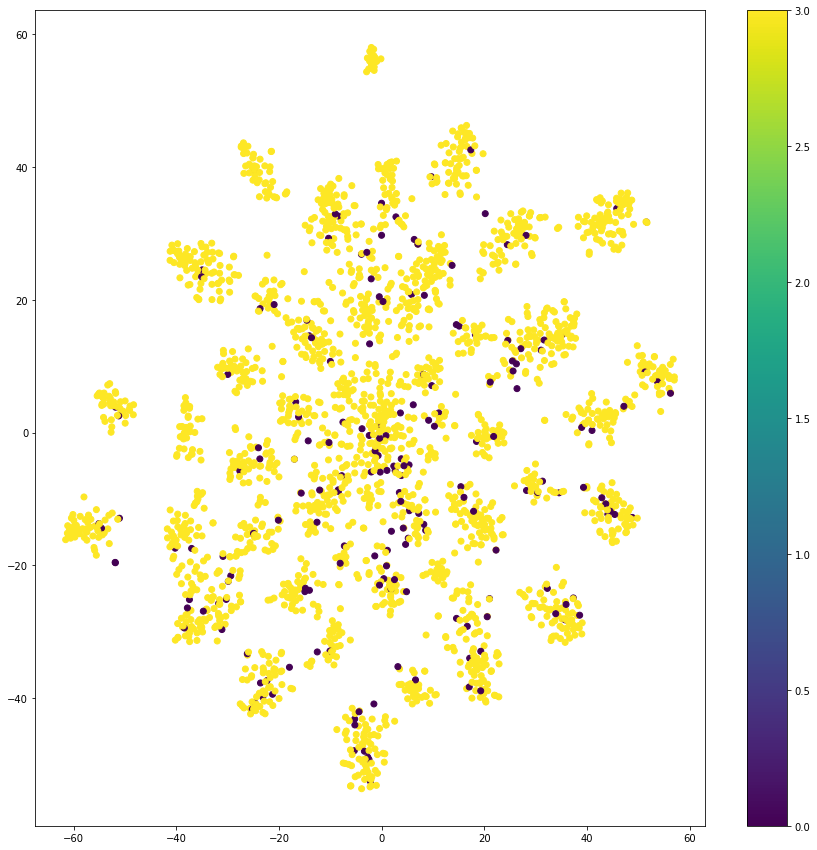

In [70]:
# plot the result according the topics
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = np.argpartition(X_mnf, 0)[:, 3] ## Change the topic number here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

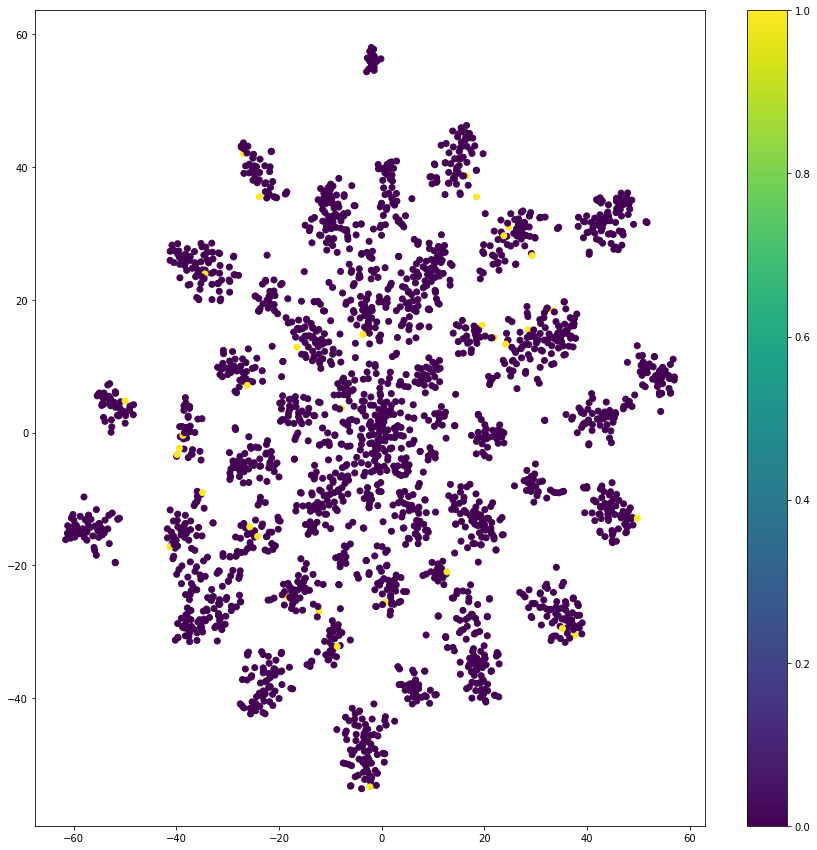

In [71]:
# plot the result according the labels
vis_x = X_tsne[:, 0]
vis_y = X_tsne[:, 1]
colors = y_test[:, 21]  ## Change the tag position here
plt.figure(figsize=(15, 15))
plt.scatter(vis_x, vis_y, c=colors, cmap=plt.cm.get_cmap(), ) 
plt.colorbar()
plt.show()

In [72]:
predict = mlb.inverse_transform(customNMF.predict(X_test))
truetag = mlb.inverse_transform(y_test)
wordtag = customNMF.predict_word(X_test)

for prediction, tags, post, keywords in zip(predict, truetag, list(X_test['TText']), wordtag):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('KEYW --> {}'.format(keywords))
    print('--------------------------------------------')

code test firefox

TRUE --> ('javascript',)
PRED --> ()
KEYW --> ['updat' 'chang' 'row' 'version' 'new' 'test' 'unit' 'mock' 'run' 'case'
 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
use text box show quantiti use button want increment decrement valu far increment work tri decrement valu put back instead go code use

TRUE --> ('c#',)
PRED --> ()
KEYW --> ['text' 'input' 'link' 'tag' 'extract' 'button' 'press' 'back' 'activ'
 'show' 'valu' 'get' 'null' 'field' 'set']
--------------------------------------------
tri creat login page use sqlite howev reason get error fatal error uncaught error call member function fetch boolean c \xampp\htdocs\project\login.php:20 stack trace main thrown c \xampp\htdocs\project\login.php line

TRUE --> ('php',)
PRED --> ('php', 'wordpress')
KEYW --> ['php' 'index' 'header' 'script' 'wordpress' 'page' 'redirect' 'login'
 'link' 'url' 'error' 'get' 'tri' 'follow' 'messag']
--------------------------------------------
latest

PRED --> ('spring',)
KEYW --> ['work' 'code' 'doe' 'tri' 'whi' 'object' 'properti' 'type' 'key' 'map'
 'return' 'null' 'result' 'spring' 'whi']
--------------------------------------------
follow situat need vba formula filter raw data sheet histor two newest date alreadi done respect pivot call pivottable1 locat pivot sheet filter two date respect column date locat call `` ipg date '' code error receiv unabl get larg properti worksheetfunct class assum xlvalueequ right way filter previous defin variabl find anoth filter command work someon direct right direct

TRUE --> ('excel', 'excel-vba', 'vba')
PRED --> ('excel', 'vba')
KEYW --> ['date' 'format' 'year' 'time' 'month' 'cell' 'excel' 'sheet' 'vba' 'macro'
 'variabl' 'pass' 'program' 'name' 'global']
--------------------------------------------
fragment applic listview checkedtextview fill name sqlite databas everyth work fine checkbox check uncheck correct problem safe check textview send name next activ look solut problem found get

TRUE --> ('python',)
PRED --> ('python',)
KEYW --> ['python' 'script' 'run' 'pi' 'output' 'file' 'read' 'folder' 'upload'
 'path' 'error' 'get' 'tri' 'follow' 'messag']
--------------------------------------------
write app use vector drawabl gradient tag extens step need take devic differ api level could work icon without us manual convert svg file png file differ size typic vector icon use import android studio notic attribut like `` startx starti '' api onli sacrific precis coordinates/direct long gradient seen possibl chang attribut littl bit least gradient shown across devic api level thank

TRUE --> ('android',)
PRED --> ('api', 'css', 'html')
KEYW --> ['api' 'googl' 'get' 'token' 'request' 'file' 'read' 'folder' 'upload'
 'path' 'element' 'div' 'css' 'html' 'style']
--------------------------------------------
want select specif band togeth scale argument band getdownloadurl ca n't make work

TRUE --> ('javascript',)
PRED --> ('api',)
KEYW --> ['select' 'option' 'dropdown' 'chec

best approach access project sourc file .h/.m assets.xcasset podfil 'm use librari want access sourc file project n't want hard code anyth becaus 'm use global defin paramet guess podspec one option sure n't want call pod updat time made chang podfil see attach imag

TRUE --> ('ios',)
PRED --> ()
KEYW --> ['file' 'read' 'folder' 'upload' 'path' 'updat' 'chang' 'row' 'version'
 'new' 'imag' 'size' 'show' 'use' 'upload']
--------------------------------------------
'm use edittext drawabl background textinputlayout everi time error look like error clear touch edittext doe n't chang focus edittext edittext becom red set error clear textinputlayout 'm use ani idea solv n't use background doe n't happen

TRUE --> ('android',)
PRED --> ()
KEYW --> ['error' 'get' 'tri' 'follow' 'messag' 'like' 'would' 'way' 'look' 'use'
 'item' 'menu' 'id' 'add' 'listview']
--------------------------------------------
effici way split datafram base ident consecut element column list keep order datafram elemen

--------------------------------------------
set class chain use member typedef next follow use abov templat chain c :last follow code proper instanti object class z expect howev consid set class form inherit hierarchi follow way use templat chain c :last ani class c abov set exampl result follow compil error understand problem class v inherit typedef v next defin parent class u result compil special form templat chain v v generic one use instead v member next anyway stuck need mechan work even case class hierarchi could ps inherit class must remain public member typedef must remain public

TRUE --> ('c++',)
PRED --> ()
KEYW --> ['class' 'interfac' 'creat' 'inherit' 'instanc' 'form' 'field' 'valid'
 'submit' 'input' 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
use bootstrap setup work fine wrap bootstrap stuff stop work fix work fine use bootstrap stop work tri select .row .col-s6 seem get work use .card nth-child even hover work get chang div color ca 

 'get' 'array' 'loop' 'index' 'numpi' 'output']
--------------------------------------------
routin creat plot ggplot use like thing count everi color chang x sinc errorbar wo n't show n=1 n=0 show count label like pictur paint could add label ps tri use quosur instead data function fail miser main part question anybodi idea would help quit much

TRUE --> ('r',)
PRED --> ()
KEYW --> ['line' 'plot' 'axi' 'chart' 'graph' 'data' 'frame' 'store' 'display' 'get'
 'like' 'would' 'way' 'look' 'use']
--------------------------------------------
instanc suppos git repo two branch master brancha brancha clone use git clone -- single-branch brancha recov branch master clone repo see clone repo histori exist branch master

TRUE --> ('git',)
PRED --> ('docker',)
KEYW --> ['docker' 'contain' 'run' 'command' 'instal' 'file' 'read' 'folder'
 'upload' 'path' 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
creat div content onclick `` inform button '' valu `` inform button 

PRED --> ()
KEYW --> ['file' 'read' 'folder' 'upload' 'path' 'work' 'code' 'doe' 'tri' 'whi'
 'object' 'properti' 'type' 'key' 'map']
--------------------------------------------
issu openurl io chang number tri dial cant past actual number given first digit hope get answer reason number get pass openurl/open os dial befor get strip tri follow combin get result `` tel //+353091xxxxxx '' `` tel //353091xxxxxx '' `` tel:353-091-xxxxxx '' onli happen number reason seem issu irish countri code

TRUE --> ('ios', 'swift')
PRED --> ()
KEYW --> ['number' 'random' 'time' 'generat' 'type' 'app' 'io' 'notif' 'devic'
 'firebas' 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
attempt optim infer c++ applic segment graph chain togeth remov redund infer calcul goal segment main infer graph run input featur vector segment train model smaller classifi graph take featur vector calcul onc aforement graph return label probabl classifi way run infer onc lighter classif n time 

TRUE --> ('pandas', 'python')
PRED --> ('python',)
KEYW --> ['column' 'row' 'datafram' 'panda' 'first' 'file' 'read' 'folder' 'upload'
 'path' 'python' 'script' 'run' 'pi' 'output']
--------------------------------------------
mysql queri join tabl time insert result 5th tabl time tabl 50k record tabl 600k record dure join stop show error lost connect mysql achiev abov join first tabl join third one 4th one insert increment run thank

TRUE --> ('mysql',)
PRED --> ('mysql', 'sql')
KEYW --> ['tabl' 'sql' 'id' 'record' 'key' 'queri' 'sql' 'result' 'execut' 'count'
 'databas' 'creat' 'mysql' 'insert' 'firebas']
--------------------------------------------
press hardwar back button page noth happen howev chang content someth els like hardwar back button exit would like make hardwar back button work correct tab page preserv work default behaviour page

TRUE --> ('android', 'ionic-framework')
PRED --> ('html',)
KEYW --> ['button' 'press' 'back' 'activ' 'show' 'page' 'redirect' 'login' 'link'



TRUE --> ('jquery',)
PRED --> ()
KEYW --> ['line' 'plot' 'axi' 'chart' 'graph' 'valu' 'get' 'null' 'field' 'set'
 'data' 'frame' 'store' 'display' 'get']
--------------------------------------------
live onlin shop websit run aw machin want add new product post blog live websit without affect custom custom order use woocommerc plugin sell product onlin import local site live websit overwrit custom inform order achiev

TRUE --> ('php', 'wordpress')
PRED --> ('docker',)
KEYW --> ['docker' 'contain' 'run' 'command' 'instal' 'post' 'request' 'url' 'http'
 'respons' 'updat' 'chang' 'row' 'version' 'new']
--------------------------------------------
receiv follow error object one 's subscript fix problem thank advanc help pleas tell appropri use forum

TRUE --> ('pandas', 'python')
PRED --> ('sql',)
KEYW --> ['object' 'properti' 'type' 'key' 'map' 'tabl' 'sql' 'id' 'record' 'key'
 'error' 'get' 'tri' 'follow' 'messag']
--------------------------------------------
okey two input input1 input

whi doe angular give error function documentreference.set call invalid data data must object custom formgroup object construct someth like illustr illustr illustr object howev illustr form need get form data way object data get push form

TRUE --> ('angular', 'forms')
PRED --> ('angular',)
KEYW --> ['object' 'properti' 'type' 'key' 'map' 'form' 'field' 'valid' 'submit'
 'input' 'angular' 'servic' 'ng' 'applic' 'use']
--------------------------------------------
n length string digit number turn list iter digit want slice list digit block look like troubl find code exampl python specif slice loop ani help would appreci thank

TRUE --> ('python',)
PRED --> ('python',)
KEYW --> ['list' 'sort' 'loop' 'first' 'get' 'number' 'random' 'time' 'generat'
 'type' 'python' 'script' 'run' 'pi' 'output']
--------------------------------------------
tri code send multipl imag server retrofit 2.3.0 work send multipart data server like final retrofit interfac need send multipl imag server retrofit 2.3.

--------------------------------------------
io develop new osx face problem delet row nstableview success click button row tabl click add button delet row appear delet delet function rowcount basic variabl increment row ad decrement row delet respect ad row function data sourc

TRUE --> ('swift',)
PRED --> ()
KEYW --> ['column' 'row' 'datafram' 'panda' 'first' 'button' 'press' 'back' 'activ'
 'show' 'variabl' 'pass' 'program' 'name' 'global']
--------------------------------------------
two model user event made pivot tabl invit user event status column event model definit wrote control follow error doe someon know whi

TRUE --> ('laravel',)
PRED --> ('django', 'sql')
KEYW --> ['user' 'login' 'django' 'log' 'model' 'tabl' 'sql' 'id' 'record' 'key'
 'column' 'row' 'datafram' 'panda' 'first']
--------------------------------------------
issu queri tabl creat use aqua data studio ibm db2 databas column name ca n't specifi unless use system name tabl made short time ago n't issu queri fin

KEYW --> ['text' 'input' 'link' 'tag' 'extract' 'view' 'control' 'model' 'layout'
 'fragment' 'click' 'event' 'window' 'menu' 'link']
--------------------------------------------
function defin kotlin file want call java like give realiz paramet lambda function seem list cap instead expect defin list submiss convert class java easili call function lambda callback wrong

TRUE --> ('java',)
PRED --> ('java', 'spring', 'xml')
KEYW --> ['java' 'xml' 'spring' 'org' 'jar' 'list' 'sort' 'loop' 'first' 'get'
 'function' 'call' 'insid' 'argument' 'pass']
--------------------------------------------
limit knowledg javascript hope someon help tri w3 school stacko use document dumb question receiv variabl valu output string without quotes.th string space exampl possibl add quot string use input valu without quot pars string myvar john doe possibl add quot valu assign variabl

TRUE --> ('javascript',)
PRED --> ('string',)
KEYW --> ['variabl' 'pass' 'program' 'name' 'global' 'valu' 'get' 'null' 'fie

PRED --> ('api',)
KEYW --> ['api' 'googl' 'get' 'token' 'request' 'work' 'code' 'doe' 'tri' 'whi'
 'post' 'request' 'url' 'http' 'respons']
--------------------------------------------
use productslist.add p use entir listview get updat valu p p object instead want chang onli particular row listview depend posit code fetch data mysql ..pleas help

TRUE --> ('android',)
PRED --> ()
KEYW --> ['updat' 'chang' 'row' 'version' 'new' 'column' 'row' 'datafram' 'panda'
 'first' 'valu' 'get' 'null' 'field' 'set']
--------------------------------------------
need detect browser ie edg angular typescript possibl

TRUE --> ('angular', 'typescript')
PRED --> ('angular', 'css', 'html')
KEYW --> ['angular' 'servic' 'ng' 'applic' 'use' 'click' 'event' 'window' 'menu'
 'link' 'element' 'div' 'css' 'html' 'style']
--------------------------------------------
'm tri make imag host thath could identifi url get method i'h done like tri develop environ netbeans+glassifh everith go smooth deploy amazon web s

TRUE --> ('xml',)
PRED --> ('css', 'html')
KEYW --> ['select' 'option' 'dropdown' 'checkbox' 'box' 'element' 'div' 'css' 'html'
 'style' 'text' 'input' 'link' 'tag' 'extract']
--------------------------------------------
jumlah copi column would like see total ada dipinjam instead screenshot think problem control pleas help

TRUE --> ('jquery', 'php')
PRED --> ()
KEYW --> ['view' 'control' 'model' 'layout' 'fragment' 'column' 'row' 'datafram'
 'panda' 'first' 'like' 'would' 'way' 'look' 'use']
--------------------------------------------
two tensor one repres list vector anoth repres list indic correspond vector want get valu vector correspond index would numpi tri vector indic tensorflow tensor doe n't work way get result

TRUE --> ('numpy', 'python-3.x', 'tensorflow')
PRED --> ()
KEYW --> ['list' 'sort' 'loop' 'first' 'get' 'valu' 'get' 'null' 'field' 'set'
 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
tri deploy new cloud servic web role azur work wi

assum get xml want result happi birthday sweet konni concaten giftmessag order sequenc mention giftmessagesequ tag

TRUE --> ('xml',)
PRED --> ('css', 'html', 'java', 'spring', 'xml')
KEYW --> ['java' 'xml' 'spring' 'org' 'jar' 'email' 'send' 'messag' 'notif' 'receiv'
 'element' 'div' 'css' 'html' 'style']
--------------------------------------------
work applic display layout aircraft need display passeng seat aircraft use button display passeng seat use nest linearlayout display button grid one outer linearlayout vertic orient within outer linearlayout linearlayout horizont orient passeng seat aircraft button onc get win death error messag applic get restart put log statement code see creat button take big toll system print `` -- start '' start creat button print `` -- end '' finish creat button log whenev win death happen observ take second instanti button need get warn messag art android runtim wonder approach use solv problem mayb creat custom widget display seat aircraft

TRUE --

--------------------------------------------
java find bit odd ca n't seem creat byte stream byte array array.stream class seem onli work int long doubl tri altern like stream.of buffer arrays.aslist buffer .stream .foreach :updat stream reflect get byte miss someth implement

TRUE --> ('arrays', 'java')
PRED --> ('java', 'spring', 'xml')
KEYW --> ['java' 'xml' 'spring' 'org' 'jar' 'updat' 'chang' 'row' 'version' 'new'
 'array' 'loop' 'index' 'numpi' 'output']
--------------------------------------------
ipdb use command arg print inform provid argument method get actual arg variabl work provid data exampl code run code tri

TRUE --> ('python',)
PRED --> ()
KEYW --> ['method' 'call' 'control' 'paramet' 'use' 'variabl' 'pass' 'program'
 'name' 'global' 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
tri download specif file sql server databas use ajax web servic code work without error still ca n't download file.her code html webservic

TRUE --> ('ajax', 'a

 'instal' 'text' 'input' 'link' 'tag' 'extract']
--------------------------------------------
add new column order tabl shopper_id tri get data new column condit result return empti queri correct execut direct return correct result open cart formula mysql query- model function

TRUE --> ('mysql', 'php')
PRED --> ('spring', 'sql')
KEYW --> ['column' 'row' 'datafram' 'panda' 'first' 'return' 'null' 'result'
 'spring' 'whi' 'queri' 'sql' 'result' 'execut' 'count']
--------------------------------------------
make applic android studio need button center phone 's screen seen mani exampl center button addit onc center width button must width screen ani idea suggest exampl welcom thank

TRUE --> ('android',)
PRED --> ('css', 'html')
KEYW --> ['button' 'press' 'back' 'activ' 'show' 'text' 'input' 'link' 'tag'
 'extract' 'element' 'div' 'css' 'html' 'style']
--------------------------------------------
build autosav featur play app jqueri run return bad request error error return chrome consol

PRED --> ('sql',)
KEYW --> ['column' 'row' 'datafram' 'panda' 'first' 'select' 'option' 'dropdown'
 'checkbox' 'box' 'tabl' 'sql' 'id' 'record' 'key']
--------------------------------------------
two file app.j sheets.j would like pass data app.j sheets.j call googl sheet api return valu onc finish api call readdata function problem follow attempt return valu respons app.j sheets.readdata data return undefin believ someth callback chain allow return valu readdata pass readsheet therefor return undefin miss callback readsheet return author result miss callback function somewher els thank

TRUE --> ('api', 'javascript', 'node.js')
PRED --> ('api', 'spring')
KEYW --> ['return' 'null' 'result' 'spring' 'whi' 'api' 'googl' 'get' 'token'
 'request' 'app' 'io' 'notif' 'devic' 'firebas']
--------------------------------------------
'm tri inspect object new instanc creat instanc creat function dayschedule.cr becaus set attribut vb_predeclaredid true 's code function problem whenev open local w

TRUE --> ('excel', 'vba')
PRED --> ('excel', 'python', 'vba')
KEYW --> ['cell' 'excel' 'sheet' 'vba' 'macro' 'python' 'script' 'run' 'pi' 'output'
 'email' 'send' 'messag' 'notif' 'receiv']
--------------------------------------------
use jacob oper word document web applic document error open confirm dialog continu applic stop code document error open dialog messag serious error occur last time open document whether continu open code run close dialog anyway resolv problem

TRUE --> ('java',)
PRED --> ('excel', 'vba')
KEYW --> ['error' 'get' 'tri' 'follow' 'messag' 'cell' 'excel' 'sheet' 'vba' 'macro'
 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
follow data frame plot ggplot get time seri data time across year 2008-2017 follow code howev want split singular year time set xlim doesnt chang time seri remov valu x axi split year also onc split one year time frame want add label month year dataset doesnt regular sampl date sampl frequenc within month perio


TRUE --> ('android',)
PRED --> ('spring',)
KEYW --> ['item' 'menu' 'id' 'add' 'listview' 'button' 'press' 'back' 'activ' 'show'
 'return' 'null' 'result' 'spring' 'whi']
--------------------------------------------
'd search jetbrain folder found insid pycharm path c \users\alexc\.pycharm2017.3 's onli one folder system empti accord user exampl two folder insid system folder anyon know could download file thank advanc

TRUE --> ('java', 'python')
PRED --> ('django', 'docker')
KEYW --> ['file' 'read' 'folder' 'upload' 'path' 'user' 'login' 'django' 'log'
 'model' 'docker' 'contain' 'run' 'command' 'instal']
--------------------------------------------
'm come across mani websit could see diff b/w system.j web pack 'm abl get exact tell tell actual purpos web pack system.j actual need

TRUE --> ('angular', 'javascript')
PRED --> ()
KEYW --> ['function' 'call' 'insid' 'argument' 'pass' 'server' 'connect' 'client'
 'socket' 'side' 'app' 'io' 'notif' 'devic' 'firebas']
--------------------

build app retriev text firebas database.th text databas written hindi languag show text view hindi approach

TRUE --> ('firebase',)
PRED --> ('mysql',)
KEYW --> ['text' 'input' 'link' 'tag' 'extract' 'databas' 'creat' 'mysql' 'insert'
 'firebas' 'app' 'io' 'notif' 'devic' 'firebas']
--------------------------------------------
ok want calcul roll minimum valu data frame roll column far unabl fix start point roll end seri tri expect output print minimum next minimum found

TRUE --> ('r',)
PRED --> ()
KEYW --> ['column' 'row' 'datafram' 'panda' 'first' 'data' 'frame' 'store' 'display'
 'get' 'valu' 'get' 'null' 'field' 'set']
--------------------------------------------
'm tabl current project use datat provid search sort function tabl ad checkbox front everi row one check row later onli process check row would love abl click header checkbox well 1. sort function column well check checkbox click uncheck tick alreadi could someth like use jqueri selector checkbox find checkbox set propert

--------------------------------------------
'm tri understand 's go html page load request defer extern resourc javascript test local dns lookup requir whi seem like browser wast `` lot time '' without anyth page empti onli contain html head bodi skeleton requir javascript code call jqueri page load becaus onload event take time get trigger

TRUE --> ('javascript',)
PRED --> ('html',)
KEYW --> ['load' 'tab' 'html' 'content' 'jqueri' 'page' 'redirect' 'login' 'link'
 'url' 'test' 'unit' 'mock' 'run' 'case']
--------------------------------------------
work express nodej mongoos azur cosmos db return object connect local mongodb follow code correct return list commit object exist local mongodb howev connect azur cosmos db use primari connect string shown azur portal websit code return empti list check mongoose.connection.readyst valu addit connect azur cosmos db use robo 3t

TRUE --> ('express', 'mongodb', 'node.js')
PRED --> ('spring',)
KEYW --> ['server' 'connect' 'client' 'socket' 's

KEYW --> ['post' 'request' 'url' 'http' 'respons' 'error' 'get' 'tri' 'follow'
 'messag' 'view' 'control' 'model' 'layout' 'fragment']
--------------------------------------------
test build function forgot password send smtp .env file tri product server got messag e-mail password reset link error consol howev gmail get anyth tri mani success mail laravel gmail get singl one even spam folder seem problem

TRUE --> ('php',)
PRED --> ()
KEYW --> ['email' 'send' 'messag' 'notif' 'receiv' 'error' 'get' 'tri' 'follow'
 'messag' 'test' 'unit' 'mock' 'run' 'case']
--------------------------------------------
idiomat way unmarsh time.dur go make use time.parsedur

TRUE --> ('json',)
PRED --> ('json',)
KEYW --> ['json' 'respons' 'pars' 'convert' 'deseri' 'number' 'random' 'time'
 'generat' 'type' 'date' 'format' 'year' 'time' 'month']
--------------------------------------------
'm still quit new lagom framework 'm seek best way fetch user distribut applic app user servic work cassandra db sele

PRED --> ('mysql', 'python')
KEYW --> ['python' 'script' 'run' 'pi' 'output' 'view' 'control' 'model' 'layout'
 'fragment' 'databas' 'creat' 'mysql' 'insert' 'firebas']
--------------------------------------------
understand creat remov link chang link check caret link need get link text/html chang url check replacedata 'm sure

TRUE --> ('javascript', 'reactjs')
PRED --> ()
KEYW --> ['text' 'input' 'link' 'tag' 'extract' 'updat' 'chang' 'row' 'version'
 'new' 'page' 'redirect' 'login' 'link' 'url']
--------------------------------------------
-14 3= c give -2 python give also tri mani languag either give 1or -2 check found compil give -2 interpret give javascript interpret languag give -2 whi

TRUE --> ('c', 'python')
PRED --> ('python',)
KEYW --> ['number' 'random' 'time' 'generat' 'type' 'python' 'script' 'run' 'pi'
 'output' 'error' 'get' 'tri' 'follow' 'messag']
--------------------------------------------
'm tri use modul depend anoth librari whenev tri regist librari compon give

TRUE --> ('php',)
PRED --> ('django', 'php', 'python', 'wordpress')
KEYW --> ['python' 'script' 'run' 'pi' 'output' 'php' 'index' 'header' 'script'
 'wordpress' 'user' 'login' 'django' 'log' 'model']
--------------------------------------------
issu ad imag div .appendto 'm for-loop .bind `` load '' -handler tri mani thing noth work onli show last pictur three code pretti simpl shown anyon hint would great thank advanc

TRUE --> ('javascript', 'jquery')
PRED --> ('css', 'html')
KEYW --> ['load' 'tab' 'html' 'content' 'jqueri' 'work' 'code' 'doe' 'tri' 'whi'
 'element' 'div' 'css' 'html' 'style']
--------------------------------------------
tri insert piec html code ion-header-bar click login button need code ad top modul piec code modul anyway achiev write singl place rather ad repeat code modul

TRUE --> ('ionic-framework',)
PRED --> ('css', 'html')
KEYW --> ['work' 'code' 'doe' 'tri' 'whi' 'page' 'redirect' 'login' 'link' 'url'
 'element' 'div' 'css' 'html' 'style']
-----------------

go tensorflow tutrial rnn draw https //www.tensorflow.org/versions/master/tutorials/recurrent_quickdraw stuck execut command tensorflow throw model_dir non-empti still happen add

TRUE --> ('python', 'tensorflow')
PRED --> ('java', 'python', 'spring', 'xml')
KEYW --> ['python' 'script' 'run' 'pi' 'output' 'java' 'xml' 'spring' 'org' 'jar'
 'line' 'plot' 'axi' 'chart' 'graph']
--------------------------------------------
execut abov script without sleep prior databas creation encount follow error quick test access run docker contain within first second contain creation check defin socket file creat find alway present sleep prior databas creation uncom sleep abov code segment procedur execut without ani issu caus abov discuss issu docker contain

TRUE --> ('docker', 'mysql')
PRED --> ('docker', 'mysql')
KEYW --> ['docker' 'contain' 'run' 'command' 'instal' 'databas' 'creat' 'mysql'
 'insert' 'firebas' 'server' 'connect' 'client' 'socket' 'side']
------------------------------------------

--------------------------------------------
sinc ad kotlin android sourc intermitt failur autom build build fail occaison build say 1/10 perhap succeed error n't occur befor introduc kotlin n't occur build local dev machines- onli build server build via command line i.e gradlew assembleflavour1flavour2 get follow error plugin id com.android.appl found howev build android studio build server jenkin slave get slight differ error plugin id kotlin-android found updat android studio file set system set updat kotlin android studio tool kotlin configur kotlin plugin updat root build.gradl follow applic build.gradl app/build.gradl senset business-specif part redact follow complet full output command-lin -- stacktrac gradlew -v report follow version info accord sdk manag within android studio follow sdk platform instal android api rev android 8.0 oreo rev follow sdk tool instal android sdk build-tool android emul 27.0.2 n.b machin vm emul doe n't work android sdk platform-tool 27.0.1 android s

 'respons' 'work' 'code' 'doe' 'tri' 'whi']
--------------------------------------------
share data fragment close activity/frag search figur reason doe send text want want fragment close code

TRUE --> ('android',)
PRED --> ()
KEYW --> ['text' 'input' 'link' 'tag' 'extract' 'data' 'frame' 'store' 'display'
 'get' 'email' 'send' 'messag' 'notif' 'receiv']
--------------------------------------------
set creat instanc 's properti django-rest-framework see tri rewrit perform_cr method find instanc 's param access requir edit know use apiview post method achiev fit simplic conveni drf want drf possibl

TRUE --> ('django', 'python')
PRED --> ('mysql',)
KEYW --> ['method' 'call' 'control' 'paramet' 'use' 'object' 'properti' 'type' 'key'
 'map' 'databas' 'creat' 'mysql' 'insert' 'firebas']
--------------------------------------------
come angular valid saw differ approach basic use either html5 template/model bind form assign valid howev come special rule need lot code templat bind form resu

In [73]:
params = {'clf_ntopics': 3,
 'clf_ntopwords': 10,
 'clf_merge':True,
 'clf_serie':['TText', 'TTitle'],
 'nmf_n_components': 50,
 'nmf_random_state': 0,
 'nmf_alpha':0,
 'nmf_l1_ratio':0,
 'vect_1_max_df': 1.,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'clf_ntopwords': [5],
              'clf_merge': [True, False],
              'clf_serie':[['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']],
              'nmf_alpha':np.arange(0,.251,.25/4),
              'nmf_l1_ratio':np.arange(0,.1251,.125/3),
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0 
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=15.166666666666668, total=  15.8s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=15.166666666666668, total=  16.9s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_l1_ra

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.6min


[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=16.0, total=  14.3s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0416666666667, score=18.5, total=  17.1s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, score=16.0, total=  11.2s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.1875, nmf_l1_ratio=0.0833333333333, sc

[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=18.0, total=  37.6s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0416666666667, score=19.5, total=  28.1s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.0833333333333, score=17.5, total=  27.3s
[CV] clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.125, nmf_l1_ratio=0.125 
[CV]  clf_merge=True, clf_ntopwords=5, clf_serie=['TText', 'TTit

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=14.08333333333333, total=  18.8s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0, score=13.83333333333333, total=  25.6s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0416666666667, score=13.333333333333334, total=  26.8s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle'], nmf_alpha=0.0625, nmf_l1_ratio=0.0833333333333, score=14.000000000000002, total=  22.2s
[CV] clf_merge=False, clf_ntopword

[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0, score=11.333333333333332, total=  37.8s


[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 15.7min


[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=14.666666666666666, total=  19.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0416666666667, score=11.333333333333332, total=  37.9s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.0833333333333, score=14.666666666666666, total=  17.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.0, nmf_l1_ratio=0.125 
[CV]  clf_merge=False, clf_nt

[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.1875, nmf_l1_ratio=0.125, score=13.5, total=  27.7s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=11.833333333333332, total=  25.3s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0, score=15.333333333333332, total=  19.0s
[CV] clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0833333333333 
[CV]  clf_merge=False, clf_ntopwords=5, clf_serie=['TText', 'TTitle', 'TCode'], nmf_alpha=0.25, nmf_l1_ratio=0.0416666666667, score=11.333333333333332, total=  20.3s
[CV] cl

[Parallel(n_jobs=3)]: Done 160 out of 160 | elapsed: 21.1min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=10, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0, nmf_init='nndsvd',
     nmf_l1_ratio=0, nmf_n_components=50, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_ngra...
     vect_3_max_df=1.0, vect_3_max_features=15000, vect_3_min_df=5,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'clf_ntopwords': [5], 'clf_merge': [True, False], 'clf_serie': [['TText', 'TTitle'], ['TText', 'TTitle', 'TCode']], 'nmf_alpha': array([ 0.    ,  0.0625,  0.125 ,  0.1875,  0.25  ]), 'nmf_l1_ratio': array([ 0.     ,  0.04167,  0.08333,  0.125  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [74]:
clf.best_score_

19.5

In [75]:
clf.best_params_

{'clf_merge': True,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.1875,
 'nmf_l1_ratio': 0.125}

In [76]:
{**params, **clf.best_params_}

{'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.1875,
 'nmf_l1_ratio': 0.125,
 'nmf_n_components': 50,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
 'vect_2_max_df': 1.0,
 'vect_2_max_features': 15000,
 'vect_2_min_df': 5,
 'vect_2_ngram_range': (1, 1),
 'vect_3_max_df': 1.0,
 'vect_3_max_features': 15000,
 'vect_3_min_df': 5,
 'vect_3_ngram_range': (1, 1)}

## Gridsearch to optimize tags research

In [77]:
#Metrics creation

scorer = make_scorer(f1_score, average='micro')
#scorer = make_scorer(label_ranking_average_precision_score, needs_proba=False)
#scorer = {'f1':make_scorer(f1_score, average='micro'), 'lra':make_scorer(label_ranking_average_precision_score, needs_proba=True)}


In [78]:
params = {'clf_merge': True,
 'clf_ntopics': 3,
 'clf_ntopwords': 5,
 'clf_serie': ['TText', 'TTitle'],
 'nmf_alpha': 0.0,
 'nmf_l1_ratio': 0.0,
 'nmf_n_components': 50,
 'nmf_random_state': 0,
 'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 1,
 'vect_1_ngram_range': (1, 1),
}

customNMF = CustomNMF(**params)

parameters = {'vect_1_max_df': [1., .95, .9],
              'vect_1_min_df': [1, 10, 20],
              'vect_1_max_features':[15000, 12000, 17000],
              'vect_1_ngram_range':[(1,1)],
             }


clf = GridSearchCV(customNMF, parameters, cv=2, return_train_score=True, refit=True, verbose = 3, n_jobs=3, scoring=scorer)
clf.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.2504633306857294, total=   9.0s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=10, vect_1_ngram_range=(1, 1), score=0.2005012531328321, total=   7.1s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.226426703584064, total=   5.8s
[CV] vect_1_max_df=1.0, vect_1_max_features=15000, 

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.8min


[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.226426703584064, total=   5.4s
[CV] vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.22294183584506166, total=  25.9s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=20, vect_1_ngram_range=(1, 1), score=0.2073138647724283, total=   4.1s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=1, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=12000, vect_1_min_df=1, vect_1_ngram_range=(1, 1), score=0.2212424849699399, total=  30.5s
[CV] vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_df=10, vect_1_ngram_range=(1, 1) 
[CV]  vect_1_max_df=0.95, vect_1_max_features=17000, vect_1_min_

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  5.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=CustomNMF(clf_merge=True, clf_ntopics=3, clf_ntopwords=5, clf_popmax=0.15,
     clf_serie=['TText', 'TTitle'], nmf_alpha=0.0, nmf_init='nndsvd',
     nmf_l1_ratio=0.0, nmf_n_components=50, nmf_random_state=0,
     vect_1_max_df=1.0, vect_1_max_features=15000, vect_1_min_df=1,
     vect_1_n...,
     vect_3_max_df=1.0, vect_3_max_features=None, vect_3_min_df=1,
     vect_3_ngram_range=(1, 1)),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'vect_1_max_df': [1.0, 0.95, 0.9], 'vect_1_min_df': [1, 10, 20], 'vect_1_max_features': [15000, 12000, 17000], 'vect_1_ngram_range': [(1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=micro), verbose=3)

In [79]:
clf.best_score_

0.22548229190928076

In [80]:
clf.best_params_

{'vect_1_max_df': 1.0,
 'vect_1_max_features': 15000,
 'vect_1_min_df': 10,
 'vect_1_ngram_range': (1, 1)}

In [81]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.24028598072738577

In [82]:
predict = mlb.inverse_transform(clf.predict(X_test))
truetag = mlb.inverse_transform(y_test)

for prediction, tags, post in zip(predict, truetag, list(X_test['TText'])):
    print(post)
    print()
    print('TRUE --> {}'.format(tags))
    print('PRED --> {}'.format(prediction))
    print('--------------------------------------------')

code test firefox

TRUE --> ('javascript',)
PRED --> ()
--------------------------------------------
use text box show quantiti use button want increment decrement valu far increment work tri decrement valu put back instead go code use

TRUE --> ('c#',)
PRED --> ()
--------------------------------------------
tri creat login page use sqlite howev reason get error fatal error uncaught error call member function fetch boolean c \xampp\htdocs\project\login.php:20 stack trace main thrown c \xampp\htdocs\project\login.php line

TRUE --> ('php',)
PRED --> ('php',)
--------------------------------------------
latest updat android emul new featur like quick boot android cts compat googl play support perform improv etc one better android develop

TRUE --> ('android',)
PRED --> ('android',)
--------------------------------------------
tri write code game make program click move mous program couldnt click left right button exampl etc c

TRUE --> ('c', 'windows')
PRED --> ()
----------------------

work webapi2 go implement global except handl knew use iexceptionhandl iexceptionlogg also implement work fine littl bit confus scenario split scenario part except bound api need handl cours rescu iexceptionhandl iexceptionlogg interfac implement sent custom httpresponsemessag handler except owin middlewar like token api auth provid level error read custom except middl ware also need clear suggest best practic good creat custom middl ware except handl global.asax ani except mention abov n't know exact ani except possibl think yes need handl onli option global.asax application_error event respons httpresponsemessag custom model pleas give comment better way handl except object client n't get ani error full stack trace except handl sent onli custom messag client question handl owin pipelin error ani error handl point

TRUE --> ('c#',)
PRED --> ('api',)
--------------------------------------------
meteor creat databas array follow content client/main.j file insid templat helper main.html 

hi want display date mm/dd/yyyy format show '- instead '/ even open firefox show date mm-dd-yyyy format

TRUE --> ('c#', 'jquery')
PRED --> ('string',)
--------------------------------------------
suppos follow code call foo data mystr copi move result believ move c++11 style hope clarif and/or link show thank edit suppos want know answer question compil g++ c++11 later

TRUE --> ('c++',)
PRED --> ('string',)
--------------------------------------------
integr adob creativ sdk android photo editor project want add chang background featur project found default default featur sdk add pragmat default sdk use android project

TRUE --> ('android',)
PRED --> ('android',)
--------------------------------------------
make code look littl bit better made class everi page 'm creat page creat anoth instanc page load first time work well app start struggl use imag layout load imag everytim main imag global variabl n't ani huge lagg c class code pastebin https //pastebin.com/n3wvgntb also get messa

simpl run.sh file `` tester '' run.sh file excut macro exampl dyld_library_path environ variabl path use run `` tester '' type run.sh shell show ./tester error load share librari lib910.so open share object file file directori actual `` tester '' run.sh lib910.so path /home/builds/linux_x86_64_centos/bin64 doubl check path correct sure whi `` tester `` find lib910.so file familiar linux sure environ variabl also use elsewher call run.sh thus tri add export like problem still exist

TRUE --> ('bash', 'linux')
PRED --> ()
--------------------------------------------
create-react-app fail error seem like react-script expect older version depend seem like interfac problem becaus 'm abl use arrow key select new version suggest 'm abl instal `` require-from-str '' 2.02 directori yarn add npm instal 'm use osx 10.12.6 node v9.2.0 react-script 1.0.17 termin respons run `` create-react-app '' *i 'm abl select version abov hit enter return follow

TRUE --> ('javascript', 'node.js', 'reactjs')
PR

befor actual question small disclaim question given ref variabl assum 's first item array pin gc wo n't caus problem work array unsaf pointer 'm sure possibl c hope 'm wrong look il code method fix ref int variabl tri come variant work generic type 's idea assum deleg class `` mytestclass '' il idea would abl use method like would someth like work 's best way includ method written il exist .net standard 2.0 project thank bonus question seen corefx repo use `` .ilproj '' file project il class actual support vs. extens use custom script support project format know 's ilproj extens avail n't either offici compat vs2017 edit might idea solv issu consid

TRUE --> ('c#', 'visual-studio')
PRED --> ()
--------------------------------------------
run problem sever time left join jpa queri generat sql queri tabl proper order claus ca n't execut simpl exampl pseudo entiti jpa queri generat sql queri look like run becaus car_tabl declar referenc join anyth run eclipselink oracl db

TRUE --> ('java

spinner string array valu email need get email valu specif item string-array select spinner got string name/titl string array need get valu string string-array code string-array look like need get valu email select string work dont know tri way get get string somethingnam code

TRUE --> ('android', 'java', 'xml')
PRED --> ('string',)
--------------------------------------------
'm tri run multipl instanc docker imag singl node send request node allow docker load balanc instanc use run command shown contain behav expect send request anoth machin port request servic contain howev tri spin servic servic command shown get replic task run request onli return error communic servic expos port sampl includ asp.net core 2.0 api return guid uniqu instanc app control dockerfil build command run command servic command request system edit found good info beleiv need publish port `` host '' mode docs.microsoft.com/en-us/virtualization/windowscontainers/…‌​ also one one port map run contain host henc

web applic slow soap web servic integr page would effect page perform would apach continu process request anoth client wait slow soap servic p.s alreadi awar apach spawn differ process differ connect observ `` top '' command still feel one client 's soap pend effect anoth user

TRUE --> ('php',)
PRED --> ('django',)
--------------------------------------------
recent download xcode 9.2 updat project set recommend 'm get warn code place use assert eg assert '' must implement subclass '' proper altern

TRUE --> ('ios',)
PRED --> ()
--------------------------------------------
new azur work aw lambda quit time want make lambda function written py 2.7 work azur function creat new function python option thus creat javascipt creat new file delet js file tri run python file alway show error

TRUE --> ('python-2.7',)
PRED --> ('python',)
--------------------------------------------
prop set parent fix throughout lifetim compon becaus this.prop this.stat may updat asynchron reli valu calcul nex

doe anybodi know run django test use pytest-django exist e.g product databas know general unit test suppos case 'm run test heroku default django creat new test databas howev possibl heroku found solut would work without pytest-django python manage.pi test https //gist.github.com/gregsadetsky/5018173 far understood pytest-django doe n't make use test runner defin django set anybodi anoth approach run django test use pytest-django heroku e.g autom way creat test databas would happi solut well

TRUE --> ('django', 'postgresql', 'python')
PRED --> ()
--------------------------------------------
tri connect smtp server domain name throw error chang mxrecord string work anyon explain whi accept string

TRUE --> ('python', 'python-3.x')
PRED --> ('string',)
--------------------------------------------
possibl chang posit turtl consol screen main object write code move window 's 'm use python 3.4.0 window ani extra inform need pleas ask

TRUE --> ('python',)
PRED --> ('python',)
-------------

problem current ansibl playbook execut contain use `` docker '' command instead `` nvidia-dock '' done accord read tri ad devic without success docker_contain name testgpu imag `` imag '' devic /dev/nvidiactl /dev/nvidia-uvm /dev/nvidia0 /dev/nvidia-uvm-tool state start note tri differ syntax devic inlin .. still get problem command doe throw ani error expect creat docker contain imag tri start look contain log termin call throw instanc std :runtime_error cuda driver found exact error 'm get run docker run -it imag instead nvidia-dock run -it imag ani idea overrid docker command use docker_contain ansibl confirm cuda driver instal path /dev/nvidia* valid thank

TRUE --> ('docker',)
PRED --> ('docker',)
--------------------------------------------
app use import statement load scss file build fine load browser error new error append empti string src sidebar.j

TRUE --> ('reactjs',)
PRED --> ('html', 'string')
--------------------------------------------
given method use follow class tes

follow function render row base stream signalr data come anoth compon 'm tri get time differ data row base item.tim attribut valu subtract current time previous time row know abov function sort subtract base previous next valu time ca n't quit pin logic instanc would differ veri first row etc edit data stream compon follow deploymenteventmessagereceiv turn get call insid function 'm connect signalr edit updat work version insid render data stream compon ani help appreci

TRUE --> ('javascript', 'reactjs')
PRED --> ('angular',)
--------------------------------------------
echo date hh mq mr-9 date 23:59/p get return /2017-12-31 19:1 4-9 /2017-12-31 23:59/p sed -n '/ date hh mq mr-9 date 23:59/p error_log_file_nam get gese -e express char invalid rang end ani suggest 'm go wrong error_log_file_nam correct

TRUE --> ('bash',)
PRED --> ()
--------------------------------------------
recent use params.merg handl alert xss vulner need find better way handl local switch page complet fine cert

requir edit hyperlink .ppt document microsoft powerpoint document use apach poi 3.17 edit link exist .ppt document code problem hslfhyperlink.setaddress `` http //www.hello.com '' doe chang link document link get modifi generat fromjava.ppt document

TRUE --> ('java',)
PRED --> ()
--------------------------------------------
use react browserrout v4.2 navig differ state use link push state method this.props.history.push myrout url browser chang state remain unchang reload page manual see target state

TRUE --> ('reactjs',)
PRED --> ('angular', 'html')
--------------------------------------------
im pŕoject use cakephp project need read file ip add data base use php read file etc tri use cakephp doenst work code .ctp file code control return creat file object read couldnt use new splfileobject cake return error

TRUE --> ('php',)
PRED --> ()
--------------------------------------------
bindinglist bind datagrid add item list ui updat minim version code reproduc problem mainwindow.xaml m

tri chang attribut valu html respons ajax befor render question

TRUE --> ('ajax', 'javascript', 'jquery')
PRED --> ()
--------------------------------------------
web applic run server web sourc pc thin client function client connect web page pc use googl chrome browser charact font display correct thin client use iceweasel make ani chang prefer shown imag chang doe appli restart browser show initi sourc must use default one use web applic charact encod must utf-8 possibl instal new packag becaus block web server access root edit file investig edit file found /home/user/.mozilla/firefox/ tri name file prefs.j user.j simul delet noth chang solut give

TRUE --> ('javascript',)
PRED --> ()
--------------------------------------------
'm current creat alia .bash_alias close app base name app use kill grep ps awk code look like alia close='kil ps -a grep input awk `` print '' problem call close doesnt take paramat ex close firefox question way pass paramat alia insert input search googl re

middlewar group request set web upon execut processlogin control method redirect showport access_token dump screen howev upon refresh page session variabl clear strang thing instead redirect within processlogin instead dd access showport endpoint session token persist even upon refresh page multipl time read somewher session :save take save perhap asynchron might lead behaviour tri everi method session variabl persist page reload

TRUE --> ('php',)
PRED --> ('html',)
--------------------------------------------
want get valu insert game tabl databas show name genr genr tabl databas view control

TRUE --> ('laravel', 'php')
PRED --> ('sql',)
--------------------------------------------
veri basic python app ’ test get ci work gitlab-ci.yml file contain follow run window gitlab runner creat environ ok soon environ activ print job succeed never run pytest finish comment activ scraper-work line pytest run fail obvious becaus environ ’ activ ani idea ’ got wrong fyi tri environ setup activ 

look asp.net ident sampl found interest point point use guid id column.when tabl definit exampl aspnetrol tabl saw command show tabl data saw valu id realli like guid also went model folder saw roleviewmodel model decid chang column project like abov code string guid chang model long id guid id tabl definit know must chang guid string doe databas automat convert guid string mean auto increment sql server section attribut function databasegener databasegeneratedoption.ident addit follow code written guid also except encount exept `` insert statement conflict foreign key constraint '' fk_dbo.users_dbo.roles_roleid\ '' conflict occur databas '' gbdb\ '' tabl '' dbo.roles\ '' column id'.th statement termin '' -- -updat -- use entityframwork code first initi role configuration.c file creat manual guid via visual studio execut update-databas runnig seed method id chang new valu store databas n't know whi question creat string-guid type like ident id column type creat automat record second qu

first describ scenario ubuntu 14.04 spark 1.6.3 python 3.5 'm tri execut python script thru spark-submit need creat context appli sqlcontext well primarili test veri easi case pyspark consol 'm creat python script run submit-spark go thru.i never get result

TRUE --> ('python',)
PRED --> ('python',)
--------------------------------------------
want call function updatemanager.inst .add updat onlin databas onc coupl second know monitor onclick someth like stepper want watch chang valu turn setter call stepper loaded/shown screen onli valu someth els whi doe setter get call bind variabl stepper need get valu watch valu chang stepper call updatemanag current solut trigger updatemanag item load want behaviour onli need fire stepper press cours use bool check first call predictionstepp doe n't seem right also listen onpropertychang predict 'm miss model object pass updatemanag doe n't realli make sens sinc model call well could use normal button defeat purpos stepper fyi n't bind predict be

'm current tri build menu would like dynam target base button 'm press instanc jqueri code look like wonder could write someth like

TRUE --> ('javascript', 'jquery', 'string')
PRED --> ('string',)
--------------------------------------------
android application.i log various applic event occur applic like login logout etc.i use log servic core library.i written code log login event loginlog log number login number fail attempt etc.now need invok loginlog parameters/ev occur dure login log pleas give suggest thank advanc

TRUE --> ('android',)
PRED --> ('django', 'docker')
--------------------------------------------
convert json x-www-form-urlencod python use code convert differ postman-encod valu due get error get error post request

TRUE --> ('python',)
PRED --> ('json',)
--------------------------------------------
attempt use mutual inform function r packag tserieschao time seri find first minimum order determin optimum delay delay embed time seri written follow function accomplis

'm work app fire tv 'm use tv 1920px width app webview full size match_par check resolut webview window.screen.availwidth 's onli 960px could anybodi help pleas

TRUE --> ('android', 'javascript')
PRED --> ('html',)
--------------------------------------------
tri make translat button romanian tri use ro romanian ro-rro ro code locale.ro none seem work ad romanian string translat xml doe n't help seen previous post romanian support even older version also answer recommend command howev idea implement would work anyon help fix extract code give error found

TRUE --> ('android', 'string')
PRED --> ('string', 'xml')
--------------------------------------------
url valid seem cover base one ca n't allow localhost url 's want allow n't want allow simpl string like

TRUE --> ('javascript', 'regex')
PRED --> ('string',)
--------------------------------------------
wonder ani way d3 plain javascript check data type on-the-fli read data

TRUE --> ('javascript',)
PRED --> ()
--------------------

angular code abov code use rate html code see nest control give error error ng areq pleas advis done ani way fix updat use code saj get error angular.min.js:101 error ngrepeat dupe http //errors.angularjs.org/1.3.2/ngrepeat/dup p0=r 20in 20rang p1=object 3a10 p2= 7b 22stateon 3anul 2c 22stateoff 3anul 7d star vise inspect code code

TRUE --> ('angularjs', 'html', 'javascript')
PRED --> ('angular',)
--------------------------------------------
'm develop nodej applic 'm use authentif passport-google-oauth20 enabl googl plus api n't found user 's phone number result api get inform googl

TRUE --> ('node.js',)
PRED --> ('api', 'django')
--------------------------------------------
'm tri expos contain port launch follow command result docker ps p.s contain ip address 172.17.0.2 tri establish test host tcp connect container1 port use got port use nc -p connect deni rest

TRUE --> ('docker',)
PRED --> ('docker',)
--------------------------------------------
valu type dynam json represent lo

'm tri use mybati cursor mapper xml mapper interfac spring servic actual queri yield non empti result cursor empti wrong

TRUE --> ('spring',)
PRED --> ('docker', 'sql', 'xml')
--------------------------------------------
client gave url press kit befor websit done gave page make websit one page site took url made code redirect scroll part site onlin n't work proper fuzzripper.com/bio give intern server error fuzzripper.com/bio.html work fine would like work even user doe n't type .html redirect code

TRUE --> ('html',)
PRED --> ('html',)
--------------------------------------------
simpl demo problem program produc output text text rather evid shini store express pass rendertext line mark problem evalu for-loop finish express depend variabl final valu use evalu express produc correct output forc shini use differ valu differ express still use loop code loop limit dynam replac loop sever static call

TRUE --> ('r',)
PRED --> ()
--------------------------------------------
set pagin repo

current multilingu angularj app input multipl valu languag en fa ar like html js mean want ng-model like last want createmodel

TRUE --> ('angularjs',)
PRED --> ()
--------------------------------------------
model option higher-ord function unit want call function 'm wonder call even option know work someth similar swift could know mayb last one `` better '' way go know `` better '' way thank

TRUE --> ('android',)
PRED --> ()
--------------------------------------------
creat mobil applic struggl upload server nodej databas postgr use pgadmin realli understand upload databas onlin amazon server tri research find look like know look onli thing found way export tabl one one csv n't way export file keep updat onc databas updat sorri thing n't clear hesit ask detail

TRUE --> ('amazon-web-services', 'node.js', 'postgresql')
PRED --> ()
--------------------------------------------
work django form wizard tri emul typic without redirect onli step idea would form wizard like templat id some

control two action follow signatur 'm use submit button call method save error say request ambigu method save attach error la richiesta corrent per l'azion attach nel tipo di control firstcontrol è ambigua tra metodi di azion seguenti system.web.mvc.actionresult salvadati xxx.yyy.web.ui.sun.models.first.firstmodel tipo xxx.yyy.web.ui.controllers.firstcontrol system.web.mvc.actionresult attach system.nullable`1 system.int64 system.str boolean int64 tipo xxx.yyy.web.controllers.firstcontrol wrong

TRUE --> ('asp.net', 'asp.net-mvc', 'c#')
PRED --> ()
--------------------------------------------
'm use sql queri redshift tabl ta one column comma separ valu ta want final result like anyon help

TRUE --> ('sql',)
PRED --> ()
--------------------------------------------
develop app xamarin mvvmcross simpli put app make pictur bundl togeth zip send server pictur info file work great point get system.ioexcept mani file open indic lot file open luck could find reason whi ani open file use stock

tabl `` cryptocoin '' last field `` time '' queri tabl need sort last rank save differ diff thank veri much

TRUE --> ('mysql',)
PRED --> ('sql',)
--------------------------------------------
code

TRUE --> ('jquery',)
PRED --> ()
--------------------------------------------
ran python setup.pi instal got follow output write import cubam get follow error line abov offend code cubam/annmodel.pi comment say connect share librari assum resid ../cubamcpp.so file locat far understand question share librari installed/avail directori python search resolv issu

TRUE --> ('python-2.7', 'python-3.x')
PRED --> ('python',)
--------------------------------------------
array n x x k. task sort 1st axi select 2nd axi element current like exampl input array 3x3x3 axi sort 1st element 2nd axi effici way use nditer

TRUE --> ('numpy', 'python')
PRED --> ()
--------------------------------------------
tri press ani button calcul give error unrecogn selector sent instanc 0x7f7f85e04e40 updat code swift sw

app need get current locat dure app launch main activ want ensur first find locat replac fragment becaus use latitud longitud inform homefrag purpos want use runnabl howev use get error mainact myloc class find locat dure app launch

TRUE --> ('android', 'java', 'multithreading')
PRED --> ()
--------------------------------------------
use xampp access manag databas also script regular push data databas becaus xampp access databas phpmyadmin/localhost would like see databas see phpmyadmin/localhost let 's say three user compani three differ ip need data databas would like track inde access databas data one els `` foreign '' ip achiev unfortun n't find ani use document topic aim briefli prefer achiev use xampp better altern readi chang howev xampp control panel found apache/logs/apach access.log appar contain access databas ipv6 address alway access databas localhost whole file full :1 could solut problem thank help

TRUE --> ('database',)
PRED --> ()
-----------------------------------

In [83]:
#CustomNMF saving
with open('customNMF.pickle', 'wb') as f:
    pickle.dump(customNMF, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('customNMF.pickle', 'rb') as f:
    customNMF = pickle.load(f)
customNMF

UnpicklingError: NEWOBJ class argument isn't a type object